# Instalação

Libs necessárias: pip install -r requirements.txt

In [108]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings

# 0. Lendo o arquivo

In [109]:
df = pd.read_csv( 'dataset/top10K-TMDB-movies.csv' )
df.shape

(10000, 9)

# 1. Pré-processamento da base de dados

## 1.1 Valores Ausentes

### 1.1.1 Ver se há algum valor ausente no DataFrame

Retorna `True` se houver pelo menos um valor ausente.

In [110]:
df.isnull().values.any()

np.True_

### 1.1.2 Contar quantos valores ausentes há em cada coluna

In [111]:
df.isnull().sum()

id                    0
title                 0
genre                 3
original_language     0
overview             13
popularity            0
release_date          0
vote_average          0
vote_count            0
dtype: int64

### 1.1.3 Exibir linhas que possuem valores ausentes

In [112]:
df[ df.isnull().any( axis = 1 ) ]

,id,title,genre,original_language,overview,popularity,release_date,vote_average,vote_count
3361,50472,Anplagghed al cinema,NaN,it,"A queue at the ATM machine, a displaced family...",4.420,2006-11-26,7.0,313
4150,38537,Nati stanchi,Comedy,it,NaN,5.671,2002-03-01,6.8,211
6973,31359,Would I Lie to You? 2,Comedy,fr,NaN,4.741,2001-02-07,6.2,325
7821,43211,7 Kilos in 7 Days,NaN,it,Two not very clever young doctors open a fitne...,5.885,1986-02-02,6.0,212
7941,2029,Tanguy,Comedy,fr,NaN,5.449,2001-11-21,6.0,387
8518,57114,"Amore, bugie e calcetto",NaN,en,NaN,4.709,2008-04-04,5.8,200
9293,17413,Incognito,Comedy,fr,NaN,5.602,2009-04-28,5.5,213
9440,516043,Arrivano i prof,Comedy,it,NaN,6.558,2018-05-01,5.4,337
9620,154512,Lightning Strike,Comedy,it,NaN,4.070,2012-12-13,5.3,216
9792,42426,A spasso nel tempo - L'avventura continua,"Comedy,Fantasy",it,NaN,5.020,1997-12-11,5.1,209


### 1.1.4 Removendo linhas com valores ausentes

In [113]:
df.dropna( subset = [ 'overview' ], inplace = True )
df.reset_index( drop = True, inplace = True )

## 1.2 Valores Duplicados

### 1.2.1 Ver se há alguma linha duplicada

Retorna `True` se houver ao menos uma linha duplicada

In [114]:
df.duplicated().any()

np.False_

### 1.2.2 Contar o número de linhas duplicadas

In [115]:
df.duplicated().sum()

np.int64(0)

### 1.2.3 Ver quais são as linhas duplicadas

In [116]:
df[ df.duplicated() ]

,id,title,genre,original_language,overview,popularity,release_date,vote_average,vote_count


# 2. Seleção de Atributos

## 2.1 Criação da Coluna 'tags'

Combina 'overview' e 'genre' para criar uma única string de texto por filme. Trata possíveis NaNs em 'genre' antes da concatenação.

In [117]:
df[ 'tags' ] = df[ 'overview' ] + ' ' + df[ 'genre' ]

## 2.2 Seleção de Colunas Relevantes

Mantém as colunas necessárias para identificação, vetorização e cálculo de score.

In [118]:
colunas_para_manter = [ 'id', 'title', 'overview', 'genre', 'tags', 'vote_average', 'vote_count' ]
# Verifica se todas as colunas esperadas existem no DataFrame carregado
colunas_existentes = [ col for col in colunas_para_manter if col in df.columns ]
if len( colunas_existentes ) != len( colunas_para_manter ):
    print( "\nAviso: Algumas colunas esperadas (como 'vote_average', 'vote_count') não foram encontradas no CSV." )
    print( "O cálculo de Weighted Rating e a ordenação por score podem não funcionar como esperado." )
    # Mantém apenas as colunas que de fato existem
    colunas_para_manter = colunas_existentes

df = df[ colunas_para_manter ].copy()

## 2.3 Criação do Mapeamento Título -> Índice

Cria uma Série para buscar rapidamente o índice de um filme a partir do título. drop_duplicates() trata títulos duplicados, mantendo apenas a primeira ocorrência no índice.

In [119]:
if 'title' in df.columns:
    indices = pd.Series( df.index, index = df[ 'title' ] ).drop_duplicates()
    print( "Mapeamento Título -> Índice ('indices') criado." )
else:
    print( "Erro: Coluna 'title' não encontrada. Não foi possível criar o mapeamento 'indices'." )
    indices = None

Mapeamento Título -> Índice ('indices') criado.


# 3. Similaridade de Cossenos

Imagine que cada sinopse de filme, depois de ser transformada em números (seja por Bag of Words ou TF-IDF), se torna um vetor em um espaço com muitas dimensões (onde cada dimensão corresponde a uma palavra do vocabulário).

## 3.1 **A Ideia Central**

A similaridade de cossenos **não mede a distância** entre as pontas desses vetores, mas sim o ângulo entre eles.

- Se dois vetores apontam para **direções muito parecidas**, o ângulo entre eles é pequeno, e a similaridade de cossenos é alta (próxima de 1). Isso sugere que as sinopses usam palavras/termos de forma parecida, indicando temas semelhantes.
- Se dois vetores apontam para **direções completamente diferentes** (são ortogonais, formam um ângulo de 90 graus), a similaridade de cossenos é 0. Isso sugere que as sinopses tratam de assuntos muito distintos, com poucas palavras-chave em comum.
- Se dois vetores apontam para **direções opostas**, o ângulo é de 180 graus, e a similaridade de cossenos é -1. Na prática, com vetores de texto baseados em contagens (BoW) ou TF-IDF, que geralmente não têm valores negativos, a similaridade varia entre 0 e 1.

## 3.2 **Exemplo**

Vamos simplificar muito e imaginar um vocabulário minúsculo com apenas 3 palavras: "ação", "comédia", "drama".

Agora, vamos representar 3 filmes com vetores baseados na contagem dessas palavras em suas (hipotéticas) sinopses:

- Filme A: "Muita ação e um pouco de drama."
    - Vetor A = [ação: 2, comédia: 0, drama: 1] -> [2, 0, 1]
- Filme B: "Pura ação!"
    - Vetor B = [ação: 1, comédia: 0, drama: 0] -> [1, 0, 0]
- Filme C: "Uma comédia dramática."
    - Vetor C = [ação: 0, comédia: 1, drama: 1] -> [0, 1, 1]

Agora, vamos calcular a similaridade de cossenos (sem entrar nos detalhes matemáticos exatos aqui, apenas a intuição):

- Similaridade(A, B):
    - Ambos têm "ação". O Filme A também tem "drama", o Filme B não.
    - Os vetores [2, 0, 1] e [1, 0, 0] apontam em direções relativamente parecidas (ambos têm um forte componente na dimensão "ação").
    - A similaridade de cossenos será alta, mas não 1 (porque A também tem "drama").
- Similaridade(A, C):
    - Ambos têm "drama". O Filme A tem "ação", o Filme C tem "comédia".
    - Os vetores [2, 0, 1] e [0, 1, 1] compartilham a dimensão "drama", mas divergem nas outras ("ação" vs "comédia").
    - A similaridade de cossenos será média-baixa.
- Similaridade(B, C):
    - Não compartilham nenhuma palavra do nosso vocabulário ("ação" vs "comédia", "drama").
    - Os vetores [1, 0, 0] e [0, 1, 1] apontam em direções muito diferentes.
    - A similaridade de cossenos será próxima de 0.

## 3.3 **Matematicamente**

A fórmula é:

$$
\text{similaridade(A,B)} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$

Onde:
- $ \mathbf{A} \cdot \mathbf{B} $ é o produto escalar dos vetores (soma da multiplicação de cada componente correspondente).
- $ \|\mathbf{A}\|$ e $ \|\mathbf{B}\| $ são as magnitudes (ou "comprimentos") dos vetores.

# 4. Vetorização das Sinopses

Para que os algoritmos de machine learning compreendam e processem dados textuais, como as sinopses ou tags dos filmes, precisamos primeiro convertê-los em vetores numéricos. Bag of Words (BoW) e TF-IDF são duas abordagens fundamentais e amplamente utilizadas para essa tarefa de **vetorização**.

## 4.1 Bag of Worlds (BoW)

Como primeira abordagem, utilizamos o Bag of Words (BoW). Este método representa os textos contando a frequência de cada palavra, de forma simples e direta.

**Expectativa:** Espera-se que o BoW capture similaridades baseadas na sobreposição direta de palavras-chave entre as 'tags' dos filmes. Recomendações podem ser relevantes se os filmes compartilham muitos termos descritivos, mas podem também ser influenciadas por palavras muito comuns (mesmo com stop words removidas) ou falhar em capturar relações de significado mais sutis que não envolvam as mesmas palavras exatas. É um ponto de partida para estabelecermos uma linha de base.

In [120]:
bow_vectorizer = CountVectorizer( max_features = 10000, stop_words = 'english' )
bow_matrix = bow_vectorizer.fit_transform( df[ 'tags' ].values.astype( 'U' ) ).toarray()

cosine_sim_bow = cosine_similarity( bow_matrix )

## 4.2 TF-IDF (Term Frequency-Inverse Document Frequency)

Agora, aplicamos o TF-IDF. Diferente do BoW que trata todas as palavras igualmente, o TF-IDF atribui um peso maior às palavras que são frequentes em um documento específico, mas raras no conjunto geral de documentos. Isso ajuda a destacar termos mais discriminativos.

**Expectativa:** Com o TF-IDF, espera-se uma melhoria em relação ao BoW. Ao dar mais importância a palavras potencialmente mais significativas e reduzir o peso de termos muito genéricos, as recomendações podem se tornar mais focadas nos aspectos distintivos dos filmes. É possível que vejamos recomendações mais precisas, menos influenciadas por palavras excessivamente comuns nas 'tags'.

In [121]:
tfidf_vectorizer = TfidfVectorizer( max_features = 10000, stop_words = 'english' )
tfidf_matrix = tfidf_vectorizer.fit_transform( df[ 'tags' ].values.astype( 'U' ) ).toarray()

cosine_sim_tfidf = cosine_similarity( tfidf_matrix )

# 5. Recomendação Baseada em Similaridade

Avançamos agora para uma técnica mais moderna e sofisticada: Sentence-BERT. Diferente do BoW e TF-IDF (que focam em palavras isoladas), o SBERT utiliza modelos Transformer pré-treinados para gerar embeddings que capturam o *significado semântico* do texto como um todo, considerando o contexto das palavras.

**Expectativa:** A expectativa aqui é um salto qualitativo nas recomendações. O SBERT deve ser capaz de identificar filmes similares mesmo que eles não usem exatamente as mesmas palavras-chave em suas 'tags', mas expressem ideias ou temas semanticamente próximos. Espera-se que as recomendações sejam mais contextuais, relevantes e capazes de capturar nuances de significado que os métodos anteriores não conseguiam.

## 5.1 Definição da Função `recommend_by_synopsis`

Define a função que recebe um título de filme e uma matriz de similaridade. Ela usa o mapeamento 'indices' para encontrar o filme, localiza seus scores de similaridade na matriz, ordena os outros filmes por similaridade decrescente e retorna os 'top_n' mais similares junto com seus scores.

In [122]:
def recommend_by_synopsis( titulo, cosine_sim_matrix, data = df, mapping = indices, top_n = 10 ):
    """
    Gera recomendações de filmes baseadas na similaridade de vetores.

    Retorna os títulos e suas pontuações de similaridade com o filme de entrada.

    Args:
        titulo (str): O título do filme base para a recomendação.
        cosine_sim_matrix (np.array): Matriz de similaridade de cossenos pré-calculada.
                                      Pode ser None se ocorreu erro no cálculo.
        data (pd.DataFrame): DataFrame contendo pelo menos 'title'.
        mapping (pd.Series): Mapeamento de títulos para índices do DataFrame.
                             Pode ser None se ocorreu erro na criação.
        top_n (int): Número de recomendações a serem retornadas.

    Returns:
        list: Lista de tuplas (titulo_recomendado, similaridade), ou str com erro.
    """
    # Validações iniciais
    if cosine_sim_matrix is None:
        return f"Erro: Matriz de similaridade não fornecida ou inválida."
    if mapping is None:
        return f"Erro: Mapeamento Título->Índice ('indices') não está disponível."
    if not isinstance( data, pd.DataFrame ) or 'title' not in data.columns:
        return f"Erro: DataFrame 'data' inválido ou sem coluna 'title'."

    try:
        # --- Encontra o índice do filme de entrada ---
        if titulo not in mapping:
            # Busca flexível (case-insensitive, sem espaços extras)
            matches = [ t for t in mapping.index if
                        isinstance( t, str ) and t.lower().strip() == titulo.lower().strip() ]
            if not matches: raise KeyError  # Dispara erro se não encontrar
            actual_title = matches[ 0 ]
            idx = mapping[ actual_title ]
            print( f"Nota: Buscando por '{actual_title}' (match para '{titulo}')" )
        else:
            idx = mapping[ titulo ]  # Índice do filme de entrada

        # Valida o índice
        if idx >= len( cosine_sim_matrix ):
            raise ValueError(
                    f"Índice {idx} (para '{titulo}') está fora dos limites da matriz de similaridade ({len( cosine_sim_matrix )})." )

        # --- Calcula e Ordena Similaridades ---
        # Obtém as pontuações de similaridade do filme 'idx' com todos os outros
        sim_scores = list( enumerate( cosine_sim_matrix[ idx ] ) )

        # Ordena pela similaridade (item [1] da tupla), decrescente
        sim_scores = sorted( sim_scores, key = lambda x: x[ 1 ], reverse = True )

        # --- Seleciona Top N e Formata Saída ---
        # Seleciona os top_n mais similares (excluindo o próprio filme - índice 1 em diante)
        sim_scores = sim_scores[ 1:top_n + 1 ]

        # Monta a lista de resultados (título, score)
        recomendacoes = [ ]
        for index, score in sim_scores:
            # Checa se o índice do filme recomendado é válido no DataFrame 'data'
            if index < len( data ):
                titulo_filme = data[ 'title' ].iloc[ index ]
                recomendacoes.append( (titulo_filme, score) )
            # else: # Opcional: Avisar sobre índice inválido
            #    print(f"Aviso: Índice de recomendação {index} fora dos limites do DataFrame. Ignorando.")

        if not recomendacoes:
            return "Nenhuma recomendação encontrada (após filtrar o próprio filme)."

        return recomendacoes

    except KeyError:
        suggestion = [ t for t in mapping.index if isinstance( t, str ) and titulo.lower() in t.lower() ][
                     :5 ]  # Sugestões simples
        error_msg = f"Erro: Filme '{titulo}' não encontrado no dataset."
        if suggestion: error_msg += f" Títulos similares: {suggestion}"
        return error_msg
    except ValueError as ve:
        return f"Erro de valor ao processar '{titulo}': {ve}"
    except Exception as e:
        import traceback
        print( f"Erro inesperado em recommend_by_synopsis para '{titulo}': {type( e ).__name__} - {e}" )
        # traceback.print_exc() # Descomente para ver o stack trace completo
        return "Ocorreu um erro inesperado durante a recomendação por similaridade."

## 5.2 Aplicação: Recomendações com BoW e TF-IDF

Utiliza a função `recommend_by_synopsis` para gerar recomendações para um filme de exemplo, usando as matrizes de similaridade calculadas anteriormente com Bag of Words (`cosine_sim_bow`) e TF-IDF (`cosine_sim_tfidf`). Os resultados de cada método são impressos para comparação.

In [123]:
print( "\n--- Testando Recomendações por Similaridade (BoW e TF-IDF) ---" )

# Define o filme de exemplo
filme_exemplo = "The Dark Knight Rises"
print( f"Filme de exemplo: '{filme_exemplo}'" )

# --- Teste com BoW ---
print( f"\n--- Recomendações para '{filme_exemplo}' (BoW) ---" )
# Verifica se a matriz BoW e o mapeamento 'indices' estão disponíveis
if 'cosine_sim_bow' in globals() and cosine_sim_bow is not None and indices is not None:
    recomendacoes_bow = recommend_by_synopsis( filme_exemplo, cosine_sim_matrix = cosine_sim_bow, top_n = 5 )
    # Imprime o resultado
    if isinstance( recomendacoes_bow, list ):
        if not recomendacoes_bow:
            print( "Nenhuma recomendação BoW encontrada." )
        else:
            for i, (filme, score) in enumerate( recomendacoes_bow ): print(
                    f"{i + 1}. {filme} (Similaridade: {score:.3f})" )
    else:
        print( recomendacoes_bow )  # Exibe a mensagem de erro
else:
    print( "Não foi possível gerar recomendações BoW (dependências ausentes: 'cosine_sim_bow' ou 'indices')." )

# --- Teste com TF-IDF ---
print( f"\n--- Recomendações para '{filme_exemplo}' (TF-IDF) ---" )
# Verifica se a matriz TF-IDF e o mapeamento 'indices' estão disponíveis
if 'cosine_sim_tfidf' in globals() and cosine_sim_tfidf is not None and indices is not None:
    recomendacoes_tfidf = recommend_by_synopsis( filme_exemplo, cosine_sim_matrix = cosine_sim_tfidf, top_n = 5 )
    # Imprime o resultado
    if isinstance( recomendacoes_tfidf, list ):
        if not recomendacoes_tfidf:
            print( "Nenhuma recomendação TF-IDF encontrada." )
        else:
            for i, (filme, score) in enumerate( recomendacoes_tfidf ): print(
                    f"{i + 1}. {filme} (Similaridade: {score:.3f})" )
    else:
        print( recomendacoes_tfidf )  # Exibe a mensagem de erro
else:
    print( "Não foi possível gerar recomendações TF-IDF (dependências ausentes: 'cosine_sim_tfidf' ou 'indices')." )


--- Testando Recomendações por Similaridade (BoW e TF-IDF) ---
Filme de exemplo: 'The Dark Knight Rises'

--- Recomendações para 'The Dark Knight Rises' (BoW) ---
1. Batman: The Long Halloween, Part One (Similaridade: 0.395)
2. Batman: The Long Halloween, Part Two (Similaridade: 0.382)
3. The Dark Knight (Similaridade: 0.335)
4. Batman: Gotham by Gaslight (Similaridade: 0.299)
5. Batman: The Dark Knight Returns, Part 1 (Similaridade: 0.278)

--- Recomendações para 'The Dark Knight Rises' (TF-IDF) ---
1. Batman: The Long Halloween, Part Two (Similaridade: 0.440)
2. Batman: The Long Halloween, Part One (Similaridade: 0.411)
3. The Dark Knight (Similaridade: 0.323)
4. Batman Forever (Similaridade: 0.230)
5. The Batman (Similaridade: 0.230)


# 6. Vetorização Semântica (Sentence-BERT)

Nesta seção, utiliza-se um modelo Sentence-BERT pré-treinado para gerar embeddings (vetores) que capturam o significado semântico das 'tags' dos filmes. Esta abordagem visa superar as limitações do BoW e TF-IDF, que se baseiam principalmente na frequência de palavras, capturando relações de significado mais profundas. O processo inclui salvar/carregar os embeddings para otimizar execuções futuras e o cálculo da matriz de similaridade baseada nesses embeddings.

## 6.1 Configuração do Modelo e Arquivo de Embeddings

Define qual modelo Sentence-BERT será utilizado (aqui, 'all-mpnet-base-v2', otimizado para inglês) e o nome do arquivo `.npy` onde os embeddings serão salvos ou de onde serão carregados.

In [124]:
# --- Configurações ---
MODEL_NAME_SBERT = 'all-mpnet-base-v2'
# Nome do arquivo para salvar/carregar embeddings
# (Usando o nome fixo do script original do usuário)
EMBEDDINGS_FILE_SBERT = 'movie_tags_embeddings_sbert.npy'

print( f"Modelo SBERT selecionado: {MODEL_NAME_SBERT}" )
print( f"Arquivo para embeddings: {EMBEDDINGS_FILE_SBERT}" )

Modelo SBERT selecionado: all-mpnet-base-v2
Arquivo para embeddings: movie_tags_embeddings_sbert.npy


## 6.2 Geração ou Carregamento dos Embeddings SBERT

Verifica se o arquivo `.npy` com os embeddings já existe.
- Se existir, carrega os embeddings do arquivo (rápido).
- Se não existir (ou ocorrer erro ao carregar), carrega o modelo Sentence-BERT (pode baixar na primeira vez), gera os embeddings para todas as 'tags' (processo demorado) e salva o resultado no arquivo `.npy` para uso futuro.

In [125]:
embeddings_sbert = None  # Inicializa a variável

# Verifica se o arquivo existe
if os.path.exists( EMBEDDINGS_FILE_SBERT ):
    print( f"\nTentando carregar embeddings pré-calculados de '{EMBEDDINGS_FILE_SBERT}'..." )
    try:
        embeddings_sbert = np.load( EMBEDDINGS_FILE_SBERT )
        print( f"Embeddings carregados com sucesso. Shape: {embeddings_sbert.shape}" )
        # Validação: compara o número de embeddings com o número de linhas em df
        # Presume que df (com id, title, tags) existe, conforme script original
        if 'df' in globals() and isinstance( df, pd.DataFrame ):
            if embeddings_sbert.shape[ 0 ] != len( df ):
                print(
                        f"Aviso: Número de embeddings ({embeddings_sbert.shape[ 0 ]}) "
                        f"não corresponde ao tamanho do DataFrame df ({len( df )})." )
                print( "Os embeddings serão gerados novamente." )
                embeddings_sbert = None  # Força a regeração
            else:
                print( "Número de embeddings compatível com df." )
        else:
            print( "Aviso: DataFrame df não encontrado para validação do shape dos embeddings." )
            # Prossegue com os embeddings carregados, mas avisa sobre a impossibilidade de validar o tamanho.

    except Exception as e:
        print( f"Erro ao carregar o arquivo de embeddings '{EMBEDDINGS_FILE_SBERT}': {e}" )
        print( "Os embeddings serão gerados novamente." )
        embeddings_sbert = None

# Gera os embeddings se não foram carregados
if embeddings_sbert is None:
    # Verifica se df existe antes de prosseguir
    if 'df' not in globals() or not isinstance( df, pd.DataFrame ) or 'tags' not in df.columns:
        print( "Erro fatal: DataFrame 'df' (com a coluna 'tags') não está disponível para gerar embeddings." )
        # Impede a continuação se df for essencial e não existir
        # exit() ou levantar uma exceção
    else:
        try:
            # Carrega o modelo SentenceTransformer
            print( f"\nCarregando modelo Sentence-BERT: '{MODEL_NAME_SBERT}' (pode baixar na 1ª vez)..." )
            model_sbert = SentenceTransformer( MODEL_NAME_SBERT )
            print( "Modelo carregado." )

            # Prepara a lista de 'tags' a partir de df
            print( "Preparando a lista de 'tags' para codificação (pode levar um momento)..." )
            tags_list = df[ 'tags' ].astype( str ).tolist()  # Usa df conforme script original

            # Gera os embeddings (etapa demorada)
            print( "\nGerando embeddings com Sentence-BERT... (Processo pode ser demorado)" )
            embeddings_sbert = model_sbert.encode( tags_list, show_progress_bar = True )
            print( f"\nEmbeddings gerados com sucesso! Shape: {embeddings_sbert.shape}" )

            # Salva os embeddings calculados
            try:
                print( f"Salvando embeddings em '{EMBEDDINGS_FILE_SBERT}'..." )
                np.save( EMBEDDINGS_FILE_SBERT, embeddings_sbert )
                print( "Embeddings salvos para uso futuro." )
            except Exception as e:
                print( f"Atenção: Não foi possível salvar os embeddings. Erro: {e}" )

        except ImportError:
            print(
                    "Erro: Biblioteca sentence-transformers não encontrada. Instale com: pip install sentence-transformers" )
        except Exception as e:
            print( f"\nErro crítico durante o processo do Sentence-BERT: {type( e ).__name__} - {e}" )
            print( "Verifique a conexão com a internet e se o modelo é válido." )
            # Garante que embeddings_sbert permaneça None se falhar
            embeddings_sbert = None


Tentando carregar embeddings pré-calculados de 'movie_tags_embeddings_sbert.npy'...
Embeddings carregados com sucesso. Shape: (9987, 768)
Número de embeddings compatível com df.


## 6.3 Cálculo da Matriz de Similaridade SBERT

Com os embeddings SBERT (carregados ou recém-gerados) disponíveis, calcula a matriz de similaridade de cossenos entre todos os pares de filmes. Esta matriz (`cosine_sim_sbert`) representa a similaridade semântica entre os filmes, baseada no modelo SBERT.

In [126]:
# Calcula a Similaridade de Cossenos
cosine_sim_sbert = None  # Inicializa
if embeddings_sbert is not None:
    try:
        print( "\nCalculando a matriz de similaridade de cossenos (SBERT)..." )
        # Usa a função do scikit-learn nos embeddings
        cosine_sim_sbert = cosine_similarity( embeddings_sbert )
        print( f"Matriz de similaridade (Sentence-BERT) calculada. Shape: {cosine_sim_sbert.shape}" )
    except Exception as e:
        print( f"Erro ao calcular a similaridade de cossenos com embeddings SBERT: {e}" )
else:
    print( "\nNão foi possível calcular a similaridade SBERT (embeddings não disponíveis)." )


Calculando a matriz de similaridade de cossenos (SBERT)...
Matriz de similaridade (Sentence-BERT) calculada. Shape: (9987, 9987)


## 5.4 Aplicação: Recomendações com SBERT

Utiliza a função `recommend_by_synopsis` (definida na Seção 5) para gerar recomendações para o filme de exemplo, desta vez usando a matriz de similaridade semântica `cosine_sim_sbert`. Os resultados são impressos.

In [127]:
print( "\n--- Testando Recomendações por Similaridade (Sentence-BERT) ---" )

if 'filme_exemplo' not in globals():
    filme_exemplo = "Bohemian Rhapsody"
    print( f"Aviso: 'filme_exemplo' não definido, usando '{filme_exemplo}'." )

# Verifica se a matriz de similaridade SBERT foi calculada com sucesso
if cosine_sim_sbert is not None and 'recommend_by_synopsis' in globals() and indices is not None:
    print( f"\n--- Recomendações para '{filme_exemplo}' (Sentence-BERT) ---" )

    recomendacoes_sbert = recommend_by_synopsis(
            filme_exemplo,
            cosine_sim_matrix = cosine_sim_sbert,  # Passa a matriz SBERT
            data = df,  # DataFrame original para buscar títulos
            mapping = indices,  # Mapeamento título->índice
            top_n = 5  # Número de recomendações
    )

    # Imprime o resultado
    if isinstance( recomendacoes_sbert, list ):
        if not recomendacoes_sbert:
            print( "Nenhuma recomendação SBERT encontrada." )
        else:
            for i, (filme, score) in enumerate( recomendacoes_sbert ):
                print( f"{i + 1}. {filme} (Similaridade Semântica: {score:.3f})" )
    else:
        # Imprime a mensagem de erro retornada pela função
        print( recomendacoes_sbert )
else:
    print( "\nNão é possível gerar recomendações com Sentence-BERT." )
    if cosine_sim_sbert is None: print( "  Motivo: Matriz de similaridade SBERT ausente." )
    if 'recommend_by_synopsis' not in globals(): print( "  Motivo: Função 'recommend_by_synopsis' não definida." )
    if indices is None: print( "  Motivo: Mapeamento 'indices' ausente." )


--- Testando Recomendações por Similaridade (Sentence-BERT) ---

--- Recomendações para 'The Dark Knight Rises' (Sentence-BERT) ---
1. Batman: The Long Halloween, Part Two (Similaridade Semântica: 0.836)
2. The Dark Knight (Similaridade Semântica: 0.830)
3. Batman: The Long Halloween, Part One (Similaridade Semântica: 0.806)
4. The Batman (Similaridade Semântica: 0.790)
5. Batman: Mask of the Phantasm (Similaridade Semântica: 0.780)


# 7. Cálculo do Score de Qualidade (Weighted Rating)

Calcula uma pontuação de qualidade para cada filme, baseada na sua nota média (`vote_average`) e no número de votos (`vote_count`), caso estas colunas estejam disponíveis. Utiliza a fórmula de Weighted Rating (WR) que ajusta a nota média considerando um número mínimo de votos (`m`) e a média geral de notas (`C`) do dataset. A coluna resultante 'score' será usada posteriormente para ordenar recomendações.

In [128]:
weighted_rating_calculated = False  # Flag para indicar se o cálculo foi bem sucedido

# Verifica se as colunas necessárias existem e são numéricas
required_cols = [ 'vote_average', 'vote_count' ]
if all( col in df.columns for col in required_cols ) and \
        pd.api.types.is_numeric_dtype( df[ 'vote_average' ] ) and \
        pd.api.types.is_numeric_dtype( df[ 'vote_count' ] ):

    def weighted_rating( x, m, C ):
        v = x[ 'vote_count' ]
        R = x[ 'vote_average' ]
        denominator = v + m
        if denominator == 0: return C
        # Adiciona tratamento para R ou v NaN, retornando C nesses casos
        if pd.isna( R ) or pd.isna( v ): return C
        return (v / denominator * R) + (m / denominator * C)


    # Calcula a média apenas de valores não-nulos
    C = df[ 'vote_average' ].mean( skipna = True )
    if pd.isna( C ):  # Se não há notas válidas
        C = 5.0  # Define uma média padrão (e.g., 5 em 10)
        print( f"Aviso: Não foi possível calcular C (média de 'vote_average'). Usando valor padrão {C}." )
    else:
        print( f"Média Geral de Notas (C): {C:.2f}" )

    # Define m como o quantil 90% da contagem de votos
    # Trata casos com poucos dados ou NaNs
    valid_vote_counts = df[ 'vote_count' ].dropna()
    if len( valid_vote_counts ) < 10 or valid_vote_counts.sum() == 0:  # Se há poucos dados ou só zeros/NaNs
        m = 0  # Define m=0 para não penalizar tanto nesses casos
        print( "Aviso: Poucos dados válidos em 'vote_count'. Usando m=0 (votos mínimos)." )
    else:
        m = valid_vote_counts.quantile( 0.90 )
    print( f"Votos Mínimos (m - quantil 90%): {int( m )}" )

    print( "Calculando e adicionando a coluna 'score' (Weighted Rating)..." )
    # Garante que a coluna 'score' existe antes de aplicar
    if 'score' not in df.columns:
        df[ 'score' ] = np.nan  # Cria a coluna com NaN
    df[ 'score' ] = df.apply( lambda x: weighted_rating( x, m = m, C = C ), axis = 1 )

    # Verifica se o cálculo resultou em valores válidos
    if df[ 'score' ].isnull().all():
        print(
                "Aviso: Cálculo do 'score' resultou em valores ausentes. Verifique os dados de 'vote_average'/'vote_count'." )
        df[ 'score' ] = 0.0  # Preenche com 0 para evitar erros posteriores
    else:
        print( "Coluna 'score' calculada com sucesso." )
        weighted_rating_calculated = True

else:
    print( "\nAviso: Colunas 'vote_average' ou 'vote_count' não encontradas ou não numéricas no DataFrame 'df'." )
    print( "Não foi possível calcular o Weighted Rating. A coluna 'score' terá valor padrão 0." )
    # Cria a coluna 'score' com valor padrão 0 se não existir
    if 'score' not in df.columns: df[ 'score' ] = 0.0

Média Geral de Notas (C): 6.62
Votos Mínimos (m - quantil 90%): 3789
Calculando e adicionando a coluna 'score' (Weighted Rating)...
Coluna 'score' calculada com sucesso.


# 8. Clustering de Filmes

Após gerar embeddings semânticos ricos com SBERT, exploramos uma abordagem diferente: o Clustering. Em vez de apenas encontrar os vizinhos mais próximos por similaridade direta, agrupamos *todos* os filmes em K clusters usando o algoritmo K-Means. A ideia é que cada cluster represente um grupo de filmes tematicamente coesos.

**Expectativa:** O clustering pode revelar a estrutura temática subjacente no catálogo de filmes. Para recomendação (Seção 7), espera-se que sugerir outros filmes do mesmo cluster possa levar a descobertas mais diversas ou inesperadas (serendipity) do que apenas os mais similares. A qualidade dependerá da coesão dos clusters formados e da eficácia da ordenação dos filmes dentro de cada cluster. É uma forma diferente de explorar a similaridade semântica capturada pelos embeddings SBERT.

## 8.1 Preparação e Verificação Inicial

Importa as bibliotecas específicas para clustering (se não importadas globalmente), configura para ignorar avisos comuns do K-Means e verifica se os embeddings SBERT, necessários para o clustering, estão disponíveis na memória.

In [129]:
warnings.filterwarnings( "ignore", category = FutureWarning, module = 'sklearn.cluster._kmeans' )
warnings.filterwarnings( "ignore", category = UserWarning, module = 'sklearn.cluster._kmeans' )

can_cluster: bool = False

# Verificar se temos os embeddings SBERT disponíveis
if 'embeddings_sbert' not in globals() or not isinstance( embeddings_sbert, np.ndarray ):
    print( "Erro: Embeddings SBERT ('embeddings_sbert') não encontrados ou inválidos." )
    print( "Por favor, execute a seção anterior (Sentence-BERT) para gerar ou carregar os embeddings." )
    # Pode-se interromper a execução aqui ou definir uma flag
    can_cluster = False
else:
    print( f"Verificação inicial: Usando embeddings SBERT com shape: {embeddings_sbert.shape}" )
    can_cluster = True

Verificação inicial: Usando embeddings SBERT com shape: (9987, 768)


## 8.2 Escolhendo K: Método do Cotovelo (Elbow Method)

Calcula e plota a inércia (soma das distâncias quadráticas intra-cluster) para diferentes números de clusters (K). A "dobra" ou "cotovelo" no gráfico sugere um valor de K onde adicionar mais clusters não traz um ganho proporcional na explicação da variância, indicando um possível bom número de clusters.

  Testando K=2...
  Testando K=3...
  Testando K=4...
  Testando K=5...
  Testando K=6...
  Testando K=7...
  Testando K=8...
  Testando K=9...
  Testando K=10...
  Testando K=11...
  Testando K=12...
  Testando K=13...
  Testando K=14...
  Testando K=15...
  Testando K=16...
  Testando K=17...
  Testando K=18...
  Testando K=19...
  Testando K=20...
  Testando K=21...
  Testando K=22...
  Testando K=23...
  Testando K=24...
  Testando K=25...
  Testando K=26...
  Testando K=27...
  Testando K=28...
  Testando K=29...
  Testando K=30...
  Testando K=31...
  Testando K=32...
  Testando K=33...
  Testando K=34...
  Testando K=35...
  Testando K=36...
  Testando K=37...
  Testando K=38...
  Testando K=39...
  Testando K=40...
  Testando K=41...
  Testando K=42...
  Testando K=43...
  Testando K=44...
  Testando K=45...
  Testando K=46...
  Testando K=47...
  Testando K=48...
  Testando K=49...
  Testando K=50...
Cálculo da inércia concluído.


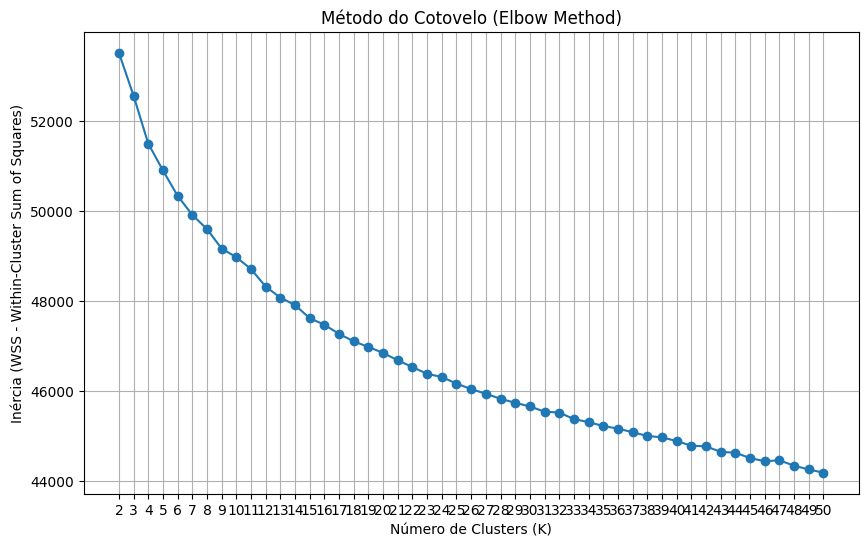

In [130]:
if can_cluster:
    inertia = [ ]
    # Define um range de K para testar (ajuste o fim do range e o passo se necessário)
    k_range = range( 2, 51, 4 )  # Ex: De 2 a 50, de 4 em 4

    try:
        for k in k_range:
            print( f"  Testando K={k}..." )
            kmeans_elbow = KMeans(
                    n_clusters = k, random_state = 42,
                    n_init = 'auto' )  # n_init='auto' é recomendado nas versões mais recentes
            kmeans_elbow.fit( embeddings_sbert )
            inertia.append( kmeans_elbow.inertia_ )
        print( "Cálculo da inércia concluído." )

        # Plotar o gráfico do cotovelo
        plt.figure( figsize = (10, 6) )
        plt.plot( k_range, inertia, marker = 'o', linestyle = '-' )
        plt.title( 'Método do Cotovelo (Elbow Method)' )
        plt.xlabel( 'Número de Clusters (K)' )
        plt.ylabel( 'Inércia (WSS - Within-Cluster Sum of Squares)' )
        plt.xticks( k_range )
        plt.grid( True )
        plt.show()
    except Exception as e:
        print( f"\nErro ao calcular o Método do Cotovelo: {e}" )

## 8.3 Escolhendo K: Pontuação de Silhueta (Silhouette Score)

Calcula e plota a pontuação média de silhueta para diferentes valores de K. Esta métrica avalia quão bem separados os clusters estão. Valores mais próximos de 1 indicam clusters mais densos e bem definidos. Um pico no gráfico sugere um valor de K ótimo.

  Testando K=2 para Silhueta...
    Calculando score para K=2...
    K=2, Silhouette Score=0.0761
  Testando K=5 para Silhueta...
    Calculando score para K=5...
    K=5, Silhouette Score=0.0523
  Testando K=8 para Silhueta...
    Calculando score para K=8...
    K=8, Silhouette Score=0.0451
  Testando K=11 para Silhueta...
    Calculando score para K=11...
    K=11, Silhouette Score=0.0414
  Testando K=14 para Silhueta...
    Calculando score para K=14...
    K=14, Silhouette Score=0.0413
  Testando K=17 para Silhueta...
    Calculando score para K=17...
    K=17, Silhouette Score=0.0408
  Testando K=20 para Silhueta...
    Calculando score para K=20...
    K=20, Silhouette Score=0.0395
  Testando K=23 para Silhueta...
    Calculando score para K=23...
    K=23, Silhouette Score=0.0399
  Testando K=26 para Silhueta...
    Calculando score para K=26...
    K=26, Silhouette Score=0.0384
  Testando K=29 para Silhueta...
    Calculando score para K=29...
    K=29, Silhouette Score=0.0375

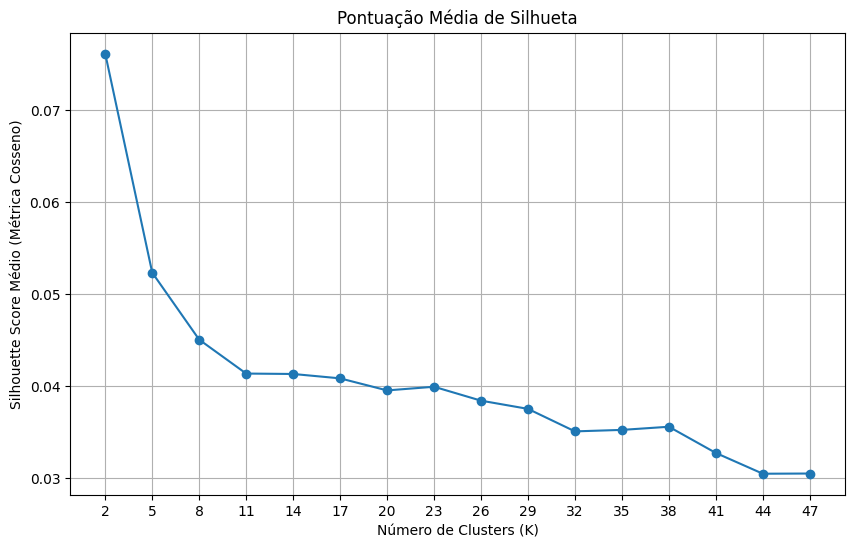

In [145]:
if can_cluster:
    calculate_silhouette = True

    if calculate_silhouette:
        silhouette_scores = [ ]
        # Usar um range menor para K devido ao custo
        k_range_silhouette = range( 2, 50, 3 )  # Ex: De 2 a 20, de 3 em 3

        try:
            for k in k_range_silhouette:
                print( f"  Testando K={k} para Silhueta..." )
                kmeans_silhouette = KMeans( n_clusters = k, random_state = 42, n_init = 'auto' )
                cluster_labels_temp = kmeans_silhouette.fit_predict( embeddings_sbert )
                print( f"    Calculando score para K={k}..." )
                score = silhouette_score(
                        embeddings_sbert, cluster_labels_temp, metric = 'cosine', sample_size = 2000,
                        random_state = 42 )
                silhouette_scores.append( score )
                print( f"    K={k}, Silhouette Score={score:.4f}" )
            print( "Cálculo da pontuação de silhueta concluído." )

            # Plotar o gráfico da silhueta
            plt.figure( figsize = (10, 6) )
            plt.plot( k_range_silhouette, silhouette_scores, marker = 'o', linestyle = '-' )
            plt.title( 'Pontuação Média de Silhueta' )
            plt.xlabel( 'Número de Clusters (K)' )
            plt.ylabel( 'Silhouette Score Médio (Métrica Cosseno)' )
            plt.xticks( k_range_silhouette )
            plt.grid( True )
            plt.show()
        except Exception as e:
            print( f"\nErro ao calcular a Pontuação de Silhueta: {e}" )

# Resumo: Por Que os Gráficos de K (Cotovelo e Silhueta) Nem Sempre Ajudam Definitivamente?

Ao tentar determinar o número ideal de clusters (K) para o K-Means usando os embeddings SBERT dos filmes, utilizamos o Método do Cotovelo e a Pontuação de Silhueta. Embora sejam ferramentas úteis, em alguns casos, como observado aqui, elas não apontam para um valor de K claro e indiscutível. As razões para isso incluem:

1.  **Pontuação de Silhueta Baixa e Sem Pico Claro:**
    * O gráfico de silhueta apresentou **valores gerais muito baixos** (bem abaixo de 0.1). Isso sugere que, pela métrica de silhueta (que prefere clusters densos e bem separados), os clusters formados pelo K-Means com os embeddings SBERT e a métrica de cosseno estão **bastante sobrepostos** ou não possuem uma separação muito nítida.
    * O **pico ocorreu em K=2**, o que é comum quando a estrutura geral é fraca. Dividir em apenas dois grandes grupos pode dar a melhor separação *matemática* (ainda que baixa), mas raramente é útil para aplicações práticas como a nossa.
    * A **ausência de um pico claro** para K > 2 significa que a métrica de silhueta não conseguiu identificar um número de clusters que seja significativamente "melhor" que os outros em termos de separação e coesão, conforme ela os mede.

2.  **Método do Cotovelo Sem "Dobra" Nítida:**
    * O gráfico do cotovelo mostrou a **diminuição esperada da inércia** à medida que K aumentava.
    * No entanto, **não houve um "cotovelo" único e agudo**. Em vez disso, a curva foi suavizando gradualmente, especialmente após K=10-12.
    * Isso torna a escolha do K baseada **apenas** no cotovelo um tanto **subjetiva**. Embora pudéssemos identificar uma *região* onde a taxa de diminuição mudava (sugerindo K entre 10-16), não havia um ponto óbvio que se destacasse como o "melhor" K de forma inequívoca.

**Causas Comuns para Essa Indefinição:**

* **Natureza dos Dados:** Embeddings de texto de alta dimensionalidade (como os do SBERT) frequentemente capturam relações semânticas complexas e nuances. Os "grupos" de filmes podem não formar clusters perfeitamente esféricos e bem separados que o K-Means e essas métricas preferem. Pode haver transições graduais entre temas ou múltiplos aspectos em um único filme.
* **Limitações do K-Means:** O K-Means funciona melhor com clusters de formato mais globular. Se os agrupamentos naturais nos seus dados tiverem formas mais complexas, o K-Means pode ter dificuldade em encontrá-los de forma otimizada, refletindo-se nas métricas.
* **Métricas são Heurísticas:** O Cotovelo e a Silhueta são heurísticas úteis, mas não garantem encontrar o número de clusters "semanticamente perfeito" ou mais útil para a aplicação final.

**Conclusão:** Os gráficos são ferramentas de diagnóstico importantes, mas não são infalíveis. Neste caso, eles indicaram uma estrutura de cluster potencialmente fraca ou complexa (Silhueta) e forneceram uma faixa de K's plausíveis em vez de um único valor (Cotovelo). Por isso, a decisão final sobre K precisou combinar a indicação da *região* do cotovelo com a **análise qualitativa** (verificar se os clusters formados com um K daquela região fazem sentido tematicamente).

## 8.4 Treinamento do Modelo K-Means Final

Com base na análise dos gráficos do Cotovelo e/ou da Silhueta, define-se o número final de clusters (K_ESCOLHIDO). Em seguida, treina-se o modelo K-Means definitivo usando todos os embeddings SBERT e o valor de K escolhido.

In [132]:
if can_cluster:
    K_ESCOLHIDO = 12

    try:
        kmeans = KMeans( n_clusters = K_ESCOLHIDO, random_state = 42, n_init = 'auto' )
        # Treina o modelo com os embeddings SBERT
        kmeans.fit( embeddings_sbert )
        print( "Treinamento K-Means final concluído." )
        clusters_generated = True
    except Exception as e:
        print( f"\nErro ao treinar o K-Means final: {e}" )
        clusters_generated = False
else:
    clusters_generated = False

Treinamento K-Means final concluído.


## 8.5 Atribuição de Rótulos e Análise dos Clusters

Obtém os rótulos de cluster atribuídos a cada filme pelo modelo K-Means treinado. Adiciona esses rótulos como uma nova coluna ao DataFrame principal (`df`). Realiza uma análise básica, mostrando a contagem de filmes por cluster e exibindo os títulos de alguns filmes de exemplo para clusters selecionados, permitindo uma verificação qualitativa da coesão dos grupos formados.

In [133]:
if clusters_generated:
    # --- Obtenção e Adição dos Rótulos ---
    cluster_labels = kmeans.labels_
    df[ 'cluster_sbert' ] = cluster_labels
    print( f"Coluna 'cluster_sbert' adicionada ao DataFrame 'df'." )

    # --- Análise dos Clusters ---
    print( "\nDistribuição de filmes por cluster (contagem):" )
    # Mostra a contagem de filmes em cada cluster, ordenado pelo número do cluster
    print( df[ 'cluster_sbert' ].value_counts().sort_index() )

    print( "\nExemplos de títulos por cluster:" )
    # Define alguns clusters para inspecionar (ex: os primeiros, um do meio, o último)
    clusters_para_inspecionar = list( range( min( 3, K_ESCOLHIDO ) ) )  # Primeiros 3
    if K_ESCOLHIDO > 5: clusters_para_inspecionar.append( K_ESCOLHIDO // 2 )  # Meio
    if K_ESCOLHIDO > 1: clusters_para_inspecionar.append( K_ESCOLHIDO - 1 )  # Último
    clusters_para_inspecionar = sorted( list( set( clusters_para_inspecionar ) ) )  # Remove duplicatas e ordena

    for cluster_num in clusters_para_inspecionar:
        print( f"\n--- Cluster {cluster_num} ---" )
        # Seleciona os primeiros N títulos do cluster atual
        filmes_no_cluster = df[ df[ 'cluster_sbert' ] == cluster_num ][ 'title' ].head( 5 ).tolist()
        if filmes_no_cluster:
            for titulo_filme in filmes_no_cluster:
                print( f"  - {titulo_filme}" )
        else:
            # Isso não deve acontecer se K foi baseado nos dados, mas é uma checagem
            print( "  (Nenhum filme encontrado neste cluster)" )

else:
    print( "\nAnálise de clusters não pode ser realizada (clustering não executado ou falhou)." )

Coluna 'cluster_sbert' adicionada ao DataFrame 'df'.

Distribuição de filmes por cluster (contagem):
cluster_sbert
0      419
1      782
2      969
3     1337
4      887
5      859
6      809
7      660
8      844
9      933
10     662
11     826
Name: count, dtype: int64

Exemplos de títulos por cluster:

--- Cluster 0 ---
  - Dilwale Dulhania Le Jayenge
  - Spirited Away
  - Your Eyes Tell
  - Dou kyu sei – Classmates
  - Your Name.

--- Cluster 1 ---
  - Psycho
  - Hope
  - Howl's Moving Castle
  - Woman in the Dunes
  - Mommy

--- Cluster 2 ---
  - Impossible Things
  - Gabriel's Inferno: Part II
  - Violet Evergarden: The Movie
  - Dedicated to my ex
  - Modern Times

--- Cluster 6 ---
  - Gabriel's Inferno
  - Gabriel's Inferno: Part III
  - Cinema Paradiso
  - Life Is Beautiful
  - City Lights

--- Cluster 11 ---
  - The Godfather
  - The Godfather: Part II
  - The Dark Knight
  - Pulp Fiction
  - GoodFellas


# 9. Recomendação Baseada em Cluster

Nesta seção, define-se e aplica-se a função `recomendar_por_cluster`. A abordagem utiliza os clusters gerados anteriormente (baseados em embeddings SBERT) para sugerir filmes. A ideia é que filmes dentro do mesmo cluster são semanticamente relacionados. As recomendações são então ordenadas pela pontuação de qualidade ('score' - Weighted Rating) para apresentar primeiro os filmes mais relevantes ou populares dentro daquele grupo temático.

## 9.1 Verificação Prévia das Colunas Necessárias

Antes de definir ou usar a função, verifica se as colunas essenciais (`cluster_sbert` e `score`) estão presentes no DataFrame `df`. Isso garante que as etapas anteriores (clustering e cálculo de score) foram executadas com sucesso e informa se a ordenação por score será possível.

In [134]:
# Presume que 'df' existe e contém os dados dos filmes
if 'df' not in globals() or not isinstance( df, pd.DataFrame ):
    print( "Erro: DataFrame 'df' não encontrado." )
    can_recommend_cluster = False
else:
    can_recommend_cluster = True
    # Verifica se a coluna de cluster existe
    if 'cluster_sbert' not in df.columns:
        print( "Erro: Coluna 'cluster_sbert' não encontrada no DataFrame 'df'." )
        print( "Execute a seção de Clustering (7) antes de continuar." )
        can_recommend_cluster = False  # Impede a execução da recomendação

    # Verifica se a coluna de score existe (para ordenação)
    if 'score' not in df.columns:
        print( "\nAviso: Coluna 'score' (Weighted Rating) não encontrada no DataFrame 'df'." )
        print( "As recomendações do cluster não serão ordenadas por qualidade/popularidade." )
        # Cria score padrão apenas para evitar erros na função, se ela for chamada
        df[ 'score' ] = 0.0
        recommend_by_score_possible = False
    elif not pd.api.types.is_numeric_dtype( df[ 'score' ] ):
        print( "\nAviso: Coluna 'score' não é numérica." )
        print( "As recomendações do cluster não serão ordenadas por qualidade/popularidade." )
        recommend_by_score_possible = False
    else:
        print( "\nColunas 'cluster_sbert' e 'score' encontradas. Ordenação por score habilitada." )
        recommend_by_score_possible = True  # Flag indicando que a ordenação por score é viável


Colunas 'cluster_sbert' e 'score' encontradas. Ordenação por score habilitada.


## 9.2 Definição da Função `recomendar_por_cluster`

Define a função que implementa a lógica de recomendação por cluster. Ela encontra o cluster do filme de entrada, busca outros filmes no mesmo cluster e os ordena pela coluna 'score' antes de retornar os melhores.

In [135]:
def recomendar_por_cluster( titulo, data = df, mapping = indices, top_n = 10 ):
    """
    Gera recomendações de filmes do mesmo cluster do filme de entrada.

    Ordena os filmes do cluster pelo 'score' (Weighted Rating) se disponível e numérico.

    Args:
        titulo (str): Título do filme base.
        data (pd.DataFrame): DataFrame com 'title', 'cluster_sbert', 'score'.
        mapping (pd.Series): Mapeamento título -> índice.
        top_n (int): Número de recomendações.

    Returns:
        list: Lista de títulos recomendados, ou str com erro.
    """
    # Verifica se as dependências estão disponíveis
    if 'cluster_sbert' not in data.columns:
        return "Erro: Coluna 'cluster_sbert' ausente no DataFrame."
    if mapping is None or not isinstance( mapping, pd.Series ):
        return "Erro: Mapeamento 'indices' inválido ou ausente."

    try:
        # Encontra o índice do filme de entrada (com busca flexível)
        if titulo not in mapping:
            matches = [ t for t in mapping.index if t.lower().strip() == titulo.lower().strip() ]
            if not matches: raise KeyError  # Dispara erro se não encontrar
            actual_title = matches[ 0 ]
            idx = mapping[ actual_title ]
        else:
            idx = mapping[ titulo ]

        # Valida o índice
        if idx >= len( data ):
            raise ValueError( f"Índice {idx} fora dos limites para o filme '{titulo}'." )

        # Obtém o cluster e título real do filme de entrada
        input_movie_cluster = data.iloc[ idx ][ 'cluster_sbert' ]
        input_movie_title = data.iloc[ idx ][ 'title' ]
        print( f"\nFilme '{input_movie_title}' (índice {idx}) pertence ao Cluster: {input_movie_cluster}" )

        # Filtra outros filmes do mesmo cluster
        cluster_movies = data[
            (data[ 'cluster_sbert' ] == input_movie_cluster) & (data.index != idx) ].copy()  # Usa .copy()

        if cluster_movies.empty:
            return f"Nenhum outro filme encontrado no Cluster {input_movie_cluster} para recomendar."
        else:
            print( f"Encontrados {len( cluster_movies )} outros filmes no Cluster {input_movie_cluster}." )

        # Ordena por 'score' se a coluna existir, for numérica e a flag global permitir
        # A flag 'recommend_by_score_possible' foi definida na célula anterior
        if recommend_by_score_possible and 'score' in cluster_movies.columns:
            cluster_movies_sorted = cluster_movies.sort_values( 'score', ascending = False )
            print( f"Ordenando recomendações por 'score' (WR)." )
        else:
            cluster_movies_sorted = cluster_movies  # Mantém ordem padrão
            if 'score' not in cluster_movies.columns:
                print( "Ordenação padrão (coluna 'score' ausente)." )
            else:
                print( "Ordenação padrão (coluna 'score' não numérica ou flag desabilitada)." )

        # Seleciona os top_n títulos
        recommendations = cluster_movies_sorted[ 'title' ].head( top_n ).tolist()

        return recommendations

    except KeyError:
        suggestion = [ t for t in mapping.index if titulo.lower() in t.lower() ][ :5 ]
        error_msg = f"Erro: Filme '{titulo}' não encontrado no dataset."
        if suggestion: error_msg += f" Títulos similares: {suggestion}"
        return error_msg
    except ValueError as ve:
        print( f"Erro de valor ao processar filme/cluster: {ve}" )
        return "Não foi possível gerar recomendações devido a um erro interno de dados."
    except Exception as e:
        # Adiciona o tipo de exceção para melhor depuração
        import traceback
        print( f"Erro inesperado em recomendar_por_cluster para '{titulo}': {type( e ).__name__} - {e}" )
        # traceback.print_exc() # Descomente para ver o stack trace completo
        return "Ocorreu um erro inesperado durante a recomendação por cluster."

## 9.3 Aplicação da Recomendação por Cluster

Executa a função `recomendar_por_cluster` para alguns filmes de exemplo e exibe os resultados. Só executa se a etapa de clustering anterior tiver sido concluída com sucesso (verificado pela existência da coluna `cluster_sbert`).

In [136]:
print( "\n--- Testando Recomendações por Cluster ---" )

# Verifica se é possível recomendar (se o clustering foi feito)
if can_recommend_cluster:
    filme_exemplo_cluster_1 = "The Dark Knight Rises"
    print( f"\nExemplo 1: Buscando recomendações para '{filme_exemplo_cluster_1}'" )

    recomendacoes_cluster_1 = recomendar_por_cluster( filme_exemplo_cluster_1, top_n = 10 )

    # Imprime o resultado (lista de filmes ou mensagem de erro)
    if isinstance( recomendacoes_cluster_1, list ):
        if not recomendacoes_cluster_1:
            print( "Nenhuma recomendação encontrada para este filme." )
        else:
            print( "\nRecomendações:" )
            for i, filme in enumerate( recomendacoes_cluster_1 ):
                print( f"  {i + 1}. {filme}" )
    else:
        print( recomendacoes_cluster_1 )  # Exibe a mensagem de erro retornada

    filme_exemplo_cluster_2 = "Avengers: Infinity War"
    print( f"\nExemplo 2: Buscando recomendações para '{filme_exemplo_cluster_2}'" )

    recomendacoes_cluster_2 = recomendar_por_cluster( filme_exemplo_cluster_2, top_n = 10 )

    # Imprime o resultado
    if isinstance( recomendacoes_cluster_2, list ):
        if not recomendacoes_cluster_2:
            print( "Nenhuma recomendação encontrada para este filme." )
        else:
            print( "\nRecomendações:" )
            for i, filme in enumerate( recomendacoes_cluster_2 ):
                print( f"  {i + 1}. {filme}" )
    else:
        print( recomendacoes_cluster_2 )  # Exibe a mensagem de erro retornada

else:
    print( "\nRecomendação por cluster não pode ser executada (etapa de clustering não concluída ou falhou)." )


--- Testando Recomendações por Cluster ---

Exemplo 1: Buscando recomendações para 'The Dark Knight Rises'

Filme 'The Dark Knight Rises' (índice 688) pertence ao Cluster: 9
Encontrados 932 outros filmes no Cluster 9.
Ordenando recomendações por 'score' (WR).

Recomendações:
  1. Inception
  2. The Green Mile
  3. Se7en
  4. Shutter Island
  5. The Silence of the Lambs
  6. Memento
  7. 12 Angry Men
  8. The Usual Suspects
  9. Kill Bill: Vol. 1
  10. Oldboy

Exemplo 2: Buscando recomendações para 'Avengers: Infinity War'

Filme 'Avengers: Infinity War' (índice 96) pertence ao Cluster: 5
Encontrados 858 outros filmes no Cluster 5.
Ordenando recomendações por 'score' (WR).

Recomendações:
  1. Interstellar
  2. Avengers: Endgame
  3. The Empire Strikes Back
  4. Back to the Future
  5. The Matrix
  6. Spider-Man: Into the Spider-Verse
  7. Star Wars
  8. WALL·E
  9. Spider-Man: No Way Home
  10. Zack Snyder's Justice League


# 9. Clustering Alternativo: DBSCAN

Como os resultados das métricas para K-Means (Cotovelo e Silhueta) não foram conclusivos, exploramos aqui um algoritmo de clustering alternativo: o DBSCAN (Density-Based Spatial Clustering of Applications with Noise).

**Por que DBSCAN?**
* Não exige a definição prévia do número de clusters (K).
* Pode encontrar clusters com formatos arbitrários (não apenas esféricos).
* É capaz de identificar pontos que não pertencem a nenhum cluster (ruído/outliers).

**Objetivo:** Tentar encontrar agrupamentos de filmes baseados na densidade dos seus embeddings SBERT no espaço vetorial, utilizando a métrica de cosseno.

### 9.1 Importações e Verificação Inicial

Importa a classe DBSCAN do Scikit-learn e outras bibliotecas necessárias para análise de parâmetros. Também verifica novamente se os embeddings SBERT estão disponíveis.

In [137]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors  # Para ajudar a escolher o 'eps'

# Verificar novamente se temos os embeddings SBERT disponíveis
if 'embeddings_sbert' not in globals() or not isinstance( embeddings_sbert, np.ndarray ):
    print( "Erro: Embeddings SBERT ('embeddings_sbert') não encontrados ou inválidos." )
    print( "Execute a seção de SBERT (5) para gerar ou carregar os embeddings." )
    can_dbscan = False
else:
    print( f"Verificação inicial: Usando embeddings SBERT com shape: {embeddings_sbert.shape}" )
    can_dbscan = True

# Define flag para indicar se DBSCAN foi executado com sucesso
dbscan_executed_successfully = False

Verificação inicial: Usando embeddings SBERT com shape: (9987, 768)


### 9.2 Escolha dos Parâmetros `eps` e `min_samples`

DBSCAN requer dois parâmetros principais:
* `eps`: A distância máxima entre duas amostras para que uma seja considerada vizinha da outra. Define o raio da vizinhança.
* `min_samples`: O número mínimo de amostras (pontos) em uma vizinhança para que um ponto seja considerado um "ponto central" (core point).

Escolher bons valores é crucial. Uma estratégia comum:
1.  Definir `min_samples`: Um valor comum para começar, especialmente com dados de alta dimensão, é um pouco maior que 1 (ex: 5, 10, 15) ou relacionado à dimensionalidade (mas `2 * dim` é geralmente impraticável aqui). Vamos tentar um valor como 10.
2.  Estimar `eps`: Calcular a distância para o k-ésimo vizinho mais próximo (onde k = `min_samples`) para todos os pontos. Plotar essas distâncias ordenadas e procurar por um "joelho" (knee) na curva, que indica um limiar de distância onde a densidade muda.

Usaremos a métrica 'cosine' para distância, apropriada para embeddings SBERT. Lembre-se que distância cosseno = 1 - similaridade cosseno.

Valor escolhido para min_samples (k para k-distance): 10
Calculando as distâncias para os 10-vizinhos mais próximos (usando métrica cosseno)...


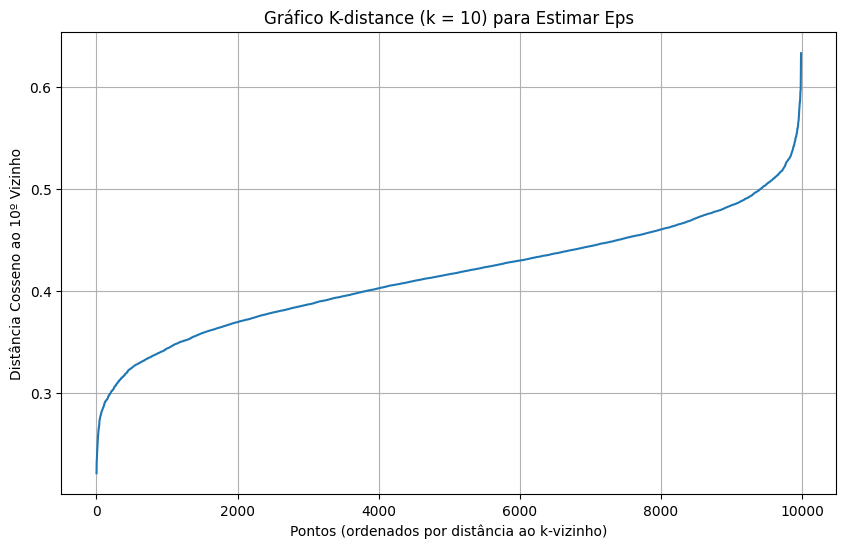


Analise o gráfico acima. Procure por um 'joelho' (knee):
O ponto onde a curva começa a subir mais acentuadamente indica um possível valor para 'eps'.
O valor de 'eps' no eixo Y correspondente a esse joelho é um bom candidato.


In [138]:
if can_dbscan:
    # --- Passo 1: Definir min_samples ---
    # Um ponto de partida razoável para dados de alta dimensão. Pode ajustar depois.
    min_samples_estimativa = 10
    print( f"Valor escolhido para min_samples (k para k-distance): {min_samples_estimativa}" )

    # --- Passo 2: Calcular e Plotar k-distance graph para estimar eps ---
    print(
            f"Calculando as distâncias para os {min_samples_estimativa}-vizinhos mais próximos (usando métrica cosseno)..." )
    try:
        # Usa NearestNeighbors para encontrar a distância até o k-ésimo vizinho (k = min_samples)
        # metric='cosine' calcula a distância cosseno (1 - similaridade)
        neighbors = NearestNeighbors( n_neighbors = min_samples_estimativa, metric = 'cosine' )
        neighbors_fit = neighbors.fit( embeddings_sbert )
        distances, indices_nn = neighbors_fit.kneighbors( embeddings_sbert )

        # Pega a distância para o k-ésimo vizinho (última coluna, pois está ordenado)
        k_distances = distances[ :, -1 ]
        # Ordena as distâncias em ordem crescente
        k_distances_sorted = np.sort( k_distances )

        # Plotar o gráfico k-distance
        plt.figure( figsize = (10, 6) )
        plt.plot( range( 1, len( k_distances_sorted ) + 1 ), k_distances_sorted )
        plt.title( f'Gráfico K-distance (k = {min_samples_estimativa}) para Estimar Eps' )
        plt.xlabel( 'Pontos (ordenados por distância ao k-vizinho)' )
        plt.ylabel( f'Distância Cosseno ao {min_samples_estimativa}º Vizinho' )
        plt.grid( True )
        # Adiciona linhas para ajudar a visualizar a região do "joelho" (opcional)
        # plt.axhline(y=0.4, color='r', linestyle='--', label='Eps=0.4?')
        # plt.axhline(y=0.5, color='g', linestyle='--', label='Eps=0.5?')
        # plt.legend()
        plt.show()

        print( "\nAnalise o gráfico acima. Procure por um 'joelho' (knee):" )
        print( "O ponto onde a curva começa a subir mais acentuadamente indica um possível valor para 'eps'." )
        print( "O valor de 'eps' no eixo Y correspondente a esse joelho é um bom candidato." )
        # Exemplo: Se o joelho está perto de eps=0.5, esse é um valor a testar.

    except Exception as e:
        print( f"\nErro ao calcular o gráfico K-distance: {e}" )
        can_dbscan = False  # Impede a execução do DBSCAN se esta etapa falhar

## 9.3 Execução do DBSCAN

Define os valores para `eps` e `min_samples` (ajuste `eps` com base no gráfico K-distance da célula anterior) e executa o algoritmo DBSCAN nos embeddings SBERT. A métrica 'cosine' é especificada diretamente.

## 9.4 Análise dos Resultados do DBSCAN

Analisa os resultados do DBSCAN:
* Calcula o número de clusters encontrados (excluindo o ruído).
* Calcula a quantidade e porcentagem de pontos classificados como ruído (rótulo -1).
* Adiciona os rótulos ao DataFrame.
* Exibe a contagem de pontos por cluster (incluindo ruído).
* Mostra exemplos de títulos de filmes para alguns clusters e para os pontos de ruído.

In [139]:
if can_dbscan:
    # --- Definição dos Parâmetros Finais ---
    # Olhe o gráfico k-distance e escolha um valor no "joelho".
    # Exemplo: Se o joelho está em torno de 0.4 ou 0.5 no eixo Y, use esse valor.
    eps_escolhido = 0.4
    min_samples_escolhido = 5

    try:
        # Instancia e treina o DBSCAN
        dbscan = DBSCAN( eps = eps_escolhido, min_samples = min_samples_escolhido, metric = 'cosine' )
        # fit_predict treina e retorna os rótulos dos clusters diretamente
        dbscan_labels = dbscan.fit_predict( embeddings_sbert )
        print( "Execução do DBSCAN concluída." )
        dbscan_executed_successfully = True

    except Exception as e:
        print( f"\nErro ao executar o DBSCAN: {e}" )
        dbscan_executed_successfully = False
else:
    print( "\nDBSCAN não pode ser executado devido a erros anteriores." )
    dbscan_executed_successfully = False

Execução do DBSCAN concluída.


In [140]:
if dbscan_executed_successfully:
    # Rótulos únicos (incluindo -1 para ruído)
    unique_labels = set( dbscan_labels )
    # Número de clusters (exclui o ruído -1)
    n_clusters_ = len( unique_labels ) - (1 if -1 in dbscan_labels else 0)
    # Número de pontos de ruído
    n_noise_ = list( dbscan_labels ).count( -1 )

    print( f"Número estimado de clusters: {n_clusters_}" )
    print( f"Número estimado de pontos de ruído: {n_noise_}" )
    if len( dbscan_labels ) > 0:
        print( f"Porcentagem de pontos de ruído: {100 * n_noise_ / len( dbscan_labels ):.2f}%" )

    # --- Adicionar Rótulos ao DataFrame ---
    # Presume que 'df' existe e está alinhado com os embeddings
    if 'df' in globals() and isinstance( df, pd.DataFrame ) and len( df ) == len( dbscan_labels ):
        df[ 'cluster_dbscan' ] = dbscan_labels
        print( "Coluna 'cluster_dbscan' adicionada ao DataFrame 'df'." )

        # --- Análise Detalhada ---
        print( "\nDistribuição de filmes por cluster (incluindo Ruído = -1):" )
        print( df[ 'cluster_dbscan' ].value_counts().sort_index() )

        # --- Exemplos de Filmes ---
        print( "\nExemplos de filmes por cluster:" )
        # Mostra exemplos dos primeiros clusters encontrados (excluindo ruído)
        clusters_reais_para_ver = [ lbl for lbl in sorted( list( unique_labels ) ) if lbl != -1 ][
                                  :min( 3, n_clusters_ ) ]  # Primeiros 3 clusters reais

        # for cluster_num in clusters_reais_para_ver:
        #     print( f"\n--- Cluster {cluster_num} ---" )
        #     filmes_no_cluster = df[ df[ 'cluster_dbscan' ] == cluster_num ][ 'title' ].head( 5 ).tolist()
        #     if filmes_no_cluster:
        #         for titulo_filme in filmes_no_cluster: print( f"  - {titulo_filme}" )
        #     else:
        #         print( "  (Cluster vazio?)" )

        # Mostra exemplos de pontos de ruído
        # if -1 in unique_labels:
        #     print( f"\n--- Pontos de Ruído (Cluster -1) ---" )
        #     filmes_ruido = df[ df[ 'cluster_dbscan' ] == -1 ][ 'title' ].head( 10 ).tolist()  # Primeiros 10 ruídos
        #     if filmes_ruido:
        #         for titulo_filme in filmes_ruido: print( f"  - {titulo_filme}" )
        #     else:
        #         print( "  (Nenhum ponto de ruído encontrado?)" )

    else:
        print( "\nNão foi possível adicionar rótulos DBSCAN ao DataFrame (df não encontrado ou tamanho incompatível)." )
else:
    print( "\nAnálise DBSCAN não pode ser realizada (execução falhou ou não ocorreu)." )


Número estimado de clusters: 4
Número estimado de pontos de ruído: 2083
Porcentagem de pontos de ruído: 20.86%
Coluna 'cluster_dbscan' adicionada ao DataFrame 'df'.

Distribuição de filmes por cluster (incluindo Ruído = -1):
cluster_dbscan
-1    2083
 0    7887
 1       8
 2       5
 3       4
Name: count, dtype: int64

Exemplos de filmes por cluster:


# ## 10. Clustering com Redução de Dimensionalidade (UMAP + K-Means)

# Como as tentativas anteriores de clustering diretamente nos embeddings SBERT de alta dimensão
# (com K-Means e DBSCAN) não produziram resultados conclusivos ou bem separados,
# exploramos agora uma abordagem combinada:
# 1.  **Redução de Dimensionalidade com UMAP:** Primeiro, usamos UMAP para reduzir
#     a dimensionalidade dos embeddings SBERT (ex: de 768 para 10 dimensões),
#     tentando preservar a estrutura semântica essencial em um espaço menor.
# 2.  **Clustering no Espaço Reduzido:** Em seguida, aplicamos um algoritmo de
#     clustering (voltaremos ao K-Means, que é mais simples de parametrizar que DBSCAN)
#     nos dados de dimensão reduzida gerados pelo UMAP.

# **Expectativa:** Espera-se que, ao operar em um espaço de dimensão menor e
# potencialmente mais "limpo", o K-Means consiga encontrar clusters mais
# significativos e que as métricas como Cotovelo e Silhueta possam fornecer
# indicações mais claras sobre o número ideal de clusters (K).

In [146]:
# pip install umap-learn # Descomente e execute se não tiver instalado

try:
    import umap.umap_ as umap  # Nova forma de importar em versões recentes

    # from umap import UMAP # Forma antiga, pode funcionar em algumas versões
    print( "Biblioteca UMAP importada com sucesso." )
except ImportError:
    print( "Erro: Biblioteca 'umap-learn' não encontrada." )
    print( "Instale com: pip install umap-learn" )
    can_umap = False
else:
    # Verifica novamente os embeddings SBERT
    if 'embeddings_sbert' not in globals() or not isinstance( embeddings_sbert, np.ndarray ):
        print( "Erro: Embeddings SBERT ('embeddings_sbert') não encontrados ou inválidos." )
        print( "Execute a seção de SBERT (5) antes de continuar." )
        can_umap = False
    else:
        print( f"Verificação: Usando embeddings SBERT com shape: {embeddings_sbert.shape}" )
        can_umap = True

# Importações adicionais para esta seção (podem já ter sido feitas)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings( "ignore", category = FutureWarning, module = 'sklearn.cluster._kmeans' )
warnings.filterwarnings( "ignore", category = UserWarning, module = 'sklearn.cluster._kmeans' )

# Flag para indicar se UMAP foi executado
umap_executed_successfully = False

Biblioteca UMAP importada com sucesso.
Verificação: Usando embeddings SBERT com shape: (9987, 768)


In [149]:
if can_umap:
    print( "\n--- 10.2 Aplicando UMAP para Redução de Dimensionalidade ---" )

    # --- Parâmetros do UMAP ---
    # Reduzir para um número baixo de dimensões (ex: 5 a 15) pode ajudar o K-Means.
    # Começar com 10 é razoável. Se quiser visualizar depois, pode tentar n_components=2.
    n_components_umap = 10
    # Mantém outros parâmetros comuns como default ou valores recomendados
    n_neighbors_umap = 15
    min_dist_umap = 0.1

    print(
            f"Configuração UMAP: n_components={n_components_umap}, n_neighbors={n_neighbors_umap}, min_dist={min_dist_umap}, metric='cosine'" )
    print( "Iniciando redução de dimensionalidade com UMAP (pode levar algum tempo)..." )

    try:
        # Instancia e aplica o UMAP
        umap_reducer = umap.UMAP(
                n_neighbors = n_neighbors_umap,
                n_components = n_components_umap,
                min_dist = min_dist_umap,
                metric = 'cosine',
                random_state = 42  # Garante reprodutibilidade
        )
        # Aplica UMAP aos embeddings SBERT originais
        embeddings_umap = umap_reducer.fit_transform( embeddings_sbert )

        print( f"Redução com UMAP concluída. Shape dos novos embeddings: {embeddings_umap.shape}" )
        umap_executed_successfully = True

    except NameError:
        print( "Erro: Classe UMAP não foi importada corretamente. Verifique a instalação de 'umap-learn'." )
        umap_executed_successfully = False
    except Exception as e:
        print( f"Erro durante a execução do UMAP: {type( e ).__name__} - {e}" )
        umap_executed_successfully = False

else:
    print( "\nNão é possível executar UMAP (embeddings SBERT ausentes)." )


--- 10.2 Aplicando UMAP para Redução de Dimensionalidade ---
Configuração UMAP: n_components=10, n_neighbors=15, min_dist=0.1, metric='cosine'
Iniciando redução de dimensionalidade com UMAP (pode levar algum tempo)...


/Users/viniciuscandeia/development/Movies/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viniciuscandeia/development/Movies/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Redução com UMAP concluída. Shape dos novos embeddings: (9987, 10)



--- 10.3 Clustering K-Means nos Dados Reduzidos por UMAP ---

Executando Método do Cotovelo nos embeddings UMAP...
  Testando K=2 (UMAP)...
  Testando K=5 (UMAP)...
  Testando K=8 (UMAP)...
  Testando K=11 (UMAP)...
  Testando K=14 (UMAP)...
  Testando K=17 (UMAP)...
  Testando K=20 (UMAP)...
  Testando K=23 (UMAP)...
  Testando K=26 (UMAP)...
  Testando K=29 (UMAP)...
Cálculo da inércia (UMAP) concluído.


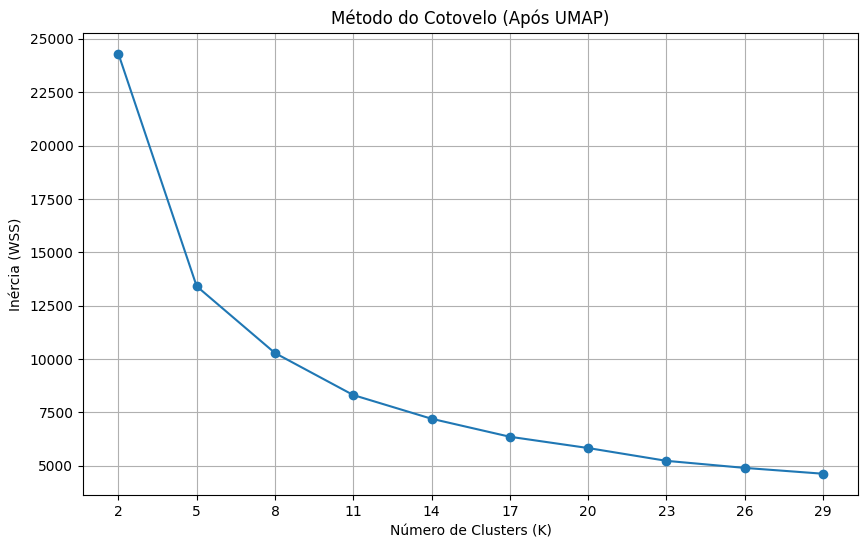

Analise o gráfico do cotovelo (UMAP) para um K ideal.

Executando Pontuação de Silhueta nos embeddings UMAP (pode demorar)...
  Testando K=2 para Silhueta (UMAP)...
    Calculando score para K=2 (UMAP)...
    K=2, Silhouette Score (UMAP)=0.3012
  Testando K=5 para Silhueta (UMAP)...
    Calculando score para K=5 (UMAP)...
    K=5, Silhouette Score (UMAP)=0.3101
  Testando K=8 para Silhueta (UMAP)...
    Calculando score para K=8 (UMAP)...
    K=8, Silhouette Score (UMAP)=0.2882
  Testando K=11 para Silhueta (UMAP)...
    Calculando score para K=11 (UMAP)...
    K=11, Silhouette Score (UMAP)=0.2885
  Testando K=14 para Silhueta (UMAP)...
    Calculando score para K=14 (UMAP)...
    K=14, Silhouette Score (UMAP)=0.2699
  Testando K=17 para Silhueta (UMAP)...
    Calculando score para K=17 (UMAP)...
    K=17, Silhouette Score (UMAP)=0.2686
  Testando K=20 para Silhueta (UMAP)...
    Calculando score para K=20 (UMAP)...
    K=20, Silhouette Score (UMAP)=0.2701
Cálculo da pontuação de silhu

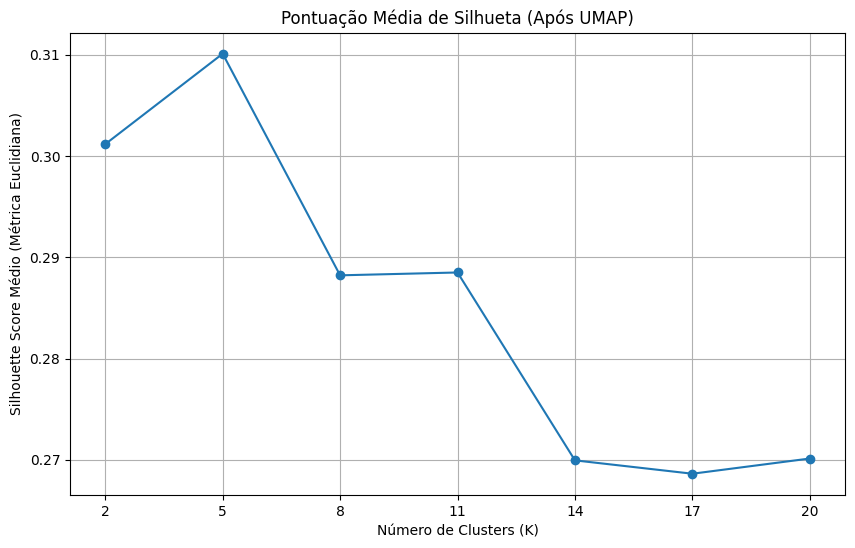

Procure por um pico no gráfico de silhueta (UMAP).

Treinando K-Means final (UMAP) com K = 15...
Treinamento K-Means final (UMAP) concluído.


In [151]:
if umap_executed_successfully:
    print( "\n--- 10.3 Clustering K-Means nos Dados Reduzidos por UMAP ---" )

    # --- Escolhendo K (Cotovelo) nos dados UMAP ---
    print( "\nExecutando Método do Cotovelo nos embeddings UMAP..." )
    inertia_umap = [ ]
    # Testar um range similar ou ligeiramente diferente de K
    k_range_umap = range( 2, 31, 3 )  # Ex: 2 a 30, de 3 em 3

    try:
        for k in k_range_umap:
            print( f"  Testando K={k} (UMAP)..." )
            kmeans_elbow_umap = KMeans( n_clusters = k, random_state = 42, n_init = 'auto' )
            kmeans_elbow_umap.fit( embeddings_umap )  # <-- FIT NOS EMBEDDINGS UMAP
            inertia_umap.append( kmeans_elbow_umap.inertia_ )
        print( "Cálculo da inércia (UMAP) concluído." )

        # Plotar Gráfico do Cotovelo (UMAP)
        plt.figure( figsize = (10, 6) )
        plt.plot( k_range_umap, inertia_umap, marker = 'o', linestyle = '-' )
        plt.title( 'Método do Cotovelo (Após UMAP)' )
        plt.xlabel( 'Número de Clusters (K)' )
        plt.ylabel( 'Inércia (WSS)' )
        plt.xticks( k_range_umap )
        plt.grid( True )
        plt.show()
        print( "Analise o gráfico do cotovelo (UMAP) para um K ideal." )

    except Exception as e:
        print( f"\nErro no Método do Cotovelo (UMAP): {e}" )

    # --- Escolhendo K (Silhueta) nos dados UMAP (Opcional) ---
    print( "\nExecutando Pontuação de Silhueta nos embeddings UMAP (pode demorar)..." )
    silhouette_scores_umap = [ ]
    # Range menor para K
    k_range_silhouette_umap = range( 2, 21, 3 )  # Ex: 2 a 20, de 3 em 3

    try:
        for k in k_range_silhouette_umap:
            print( f"  Testando K={k} para Silhueta (UMAP)..." )
            kmeans_silhouette_umap = KMeans( n_clusters = k, random_state = 42, n_init = 'auto' )
            cluster_labels_temp_umap = kmeans_silhouette_umap.fit_predict(
                    embeddings_umap )  # <-- FIT NOS EMBEDDINGS UMAP
            print( f"    Calculando score para K={k} (UMAP)..." )
            # Usar métrica padrão 'euclidean' no espaço reduzido é comum, mas 'cosine' ainda pode ser usada
            score_umap = silhouette_score(
                    embeddings_umap, cluster_labels_temp_umap, metric = 'euclidean', sample_size = 2000,
                    random_state = 42 )
            silhouette_scores_umap.append( score_umap )
            print( f"    K={k}, Silhouette Score (UMAP)={score_umap:.4f}" )
        print( "Cálculo da pontuação de silhueta (UMAP) concluído." )

        # Plotar Gráfico da Silhueta (UMAP)
        plt.figure( figsize = (10, 6) )
        plt.plot( k_range_silhouette_umap, silhouette_scores_umap, marker = 'o', linestyle = '-' )
        plt.title( 'Pontuação Média de Silhueta (Após UMAP)' )
        plt.xlabel( 'Número de Clusters (K)' )
        plt.ylabel( 'Silhouette Score Médio (Métrica Euclidiana)' )  # Ou Cosseno se usou essa
        plt.xticks( k_range_silhouette_umap )
        plt.grid( True )
        plt.show()
        print( "Procure por um pico no gráfico de silhueta (UMAP)." )

    except Exception as e:
        print( f"\nErro na Pontuação de Silhueta (UMAP): {e}" )

    # --- Treinamento Final do K-Means (UMAP) ---
    # !!! IMPORTANTE: AJUSTE O VALOR DE K_ESCOLHIDO_UMAP ABAIXO !!!
    # Analise os gráficos ACIMA (baseados em UMAP) e defina K.
    K_ESCOLHIDO_UMAP = 15  # Valor exemplo, ajuste conforme sua análise!
    print( f"\nTreinando K-Means final (UMAP) com K = {K_ESCOLHIDO_UMAP}..." )
    clusters_generated_umap = False
    try:
        kmeans_umap = KMeans( n_clusters = K_ESCOLHIDO_UMAP, random_state = 42, n_init = 'auto' )
        # Treina o modelo com os embeddings UMAP
        kmeans_umap_labels = kmeans_umap.fit_predict( embeddings_umap )
        print( "Treinamento K-Means final (UMAP) concluído." )
        clusters_generated_umap = True
    except Exception as e:
        print( f"\nErro ao treinar o K-Means final (UMAP): {e}" )

else:
    print( "\nNão é possível executar Clustering (UMAP não executado)." )
    clusters_generated_umap = False

In [153]:
if clusters_generated_umap:
    print( "\n--- 10.4 Análise dos Clusters (UMAP + K-Means) ---" )

    # Adiciona os novos rótulos ao DataFrame principal
    df[ 'cluster_umap_kmeans' ] = kmeans_umap_labels
    print( f"Coluna 'cluster_umap_kmeans' adicionada ao DataFrame 'df'." )

    # Analisa a distribuição
    print( "\nDistribuição de filmes por cluster (UMAP + K-Means):" )
    print( df[ 'cluster_umap_kmeans' ].value_counts().sort_index() )

    # Mostra exemplos de títulos para alguns clusters
    print( "\nExemplos de títulos por cluster (UMAP + K-Means):" )

    # --- CORREÇÃO AQUI ---
    # Converte o range para list() imediatamente
    clusters_para_inspecionar_umap = list( range( min( 3, K_ESCOLHIDO_UMAP ) ) )  # Primeiros 3

    # Agora podemos usar .append() na lista
    if K_ESCOLHIDO_UMAP > 5: clusters_para_inspecionar_umap.append( K_ESCOLHIDO_UMAP // 2 )  # Meio
    if K_ESCOLHIDO_UMAP > 1: clusters_para_inspecionar_umap.append( K_ESCOLHIDO_UMAP - 1 )  # Último
    # Remove duplicatas (caso K seja pequeno e os índices coincidam) e ordena
    clusters_para_inspecionar_umap = sorted( list( set( clusters_para_inspecionar_umap ) ) )
    # --- FIM DA CORREÇÃO ---

    # Itera sobre a lista final de clusters a inspecionar
    for cluster_num in clusters_para_inspecionar_umap:
        # Verifica se o número do cluster é válido (importante se K_ESCOLHIDO_UMAP for 0 ou 1)
        if cluster_num < K_ESCOLHIDO_UMAP and cluster_num >= 0:
            print( f"\n--- Cluster {cluster_num} (UMAP+KMeans) ---" )
            filmes_no_cluster = df[ df[ 'cluster_umap_kmeans' ] == cluster_num ][ 'title' ].head( 5 ).tolist()
            if filmes_no_cluster:
                for titulo_filme in filmes_no_cluster: print( f"  - {titulo_filme}" )
            else:
                print( "  (Cluster vazio ou não encontrado)" )
        else:
            print( f"Aviso: Tentando inspecionar cluster inválido {cluster_num} para K={K_ESCOLHIDO_UMAP}" )

    print( "\n--- Clustering com UMAP + K-Means Concluído ---" )

else:
    print( "\nAnálise de clusters (UMAP + K-Means) não pode ser realizada." )


--- 10.4 Análise dos Clusters (UMAP + K-Means) ---
Coluna 'cluster_umap_kmeans' adicionada ao DataFrame 'df'.

Distribuição de filmes por cluster (UMAP + K-Means):
cluster_umap_kmeans
0      420
1      842
2      636
3      814
4      951
5      527
6     1126
7      672
8      576
9      372
10     661
11     626
12     637
13     568
14     559
Name: count, dtype: int64

Exemplos de títulos por cluster (UMAP + K-Means):

--- Cluster 0 (UMAP+KMeans) ---
  - Dilwale Dulhania Le Jayenge
  - Gabriel's Inferno
  - Gabriel's Inferno: Part III
  - Hotarubi no Mori e
  - Howl's Moving Castle

--- Cluster 1 (UMAP+KMeans) ---
  - The Shawshank Redemption
  - The Godfather
  - The Godfather: Part II
  - Pulp Fiction
  - Once Upon a Time in America

--- Cluster 2 (UMAP+KMeans) ---
  - Forrest Gump
  - Cinema Paradiso
  - Sunset Boulevard
  - Whiplash
  - Given

--- Cluster 7 (UMAP+KMeans) ---
  - Parasite
  - Dead Poets Society
  - Klaus
  - I Want to Eat Your Pancreas
  - Soul

--- Cluster 14 

In [156]:
# --- Teste para um Filme Específico ---
meu_filme = "Gabriel's Inferno"
num_recomendacoes = 7  # Quantas recomendações mostrar por método

print( f"--- Buscando recomendações para: {meu_filme} ---" )

# 1. Recomendação por BoW (Similaridade)
print( f"\n--- Recomendações (BoW) ---" )
if 'cosine_sim_bow' in globals() and cosine_sim_bow is not None and indices is not None:
    recs_bow = recommend_by_synopsis( meu_filme, cosine_sim_matrix = cosine_sim_bow, top_n = num_recomendacoes )
    if isinstance( recs_bow, list ):
        for i, (filme, score) in enumerate( recs_bow ): print( f"{i + 1}. {filme} (Similaridade: {score:.3f})" )
    else:
        print( recs_bow )
else:
    print( "Dependências BoW não disponíveis." )

# 2. Recomendação por TF-IDF (Similaridade)
print( f"\n--- Recomendações (TF-IDF) ---" )
if 'cosine_sim_tfidf' in globals() and cosine_sim_tfidf is not None and indices is not None:
    recs_tfidf = recommend_by_synopsis( meu_filme, cosine_sim_matrix = cosine_sim_tfidf, top_n = num_recomendacoes )
    if isinstance( recs_tfidf, list ):
        for i, (filme, score) in enumerate( recs_tfidf ): print( f"{i + 1}. {filme} (Similaridade: {score:.3f})" )
    else:
        print( recs_tfidf )
else:
    print( "Dependências TF-IDF não disponíveis." )

# 3. Recomendação por SBERT (Similaridade Semântica)
print( f"\n--- Recomendações (SBERT - Similaridade Semântica) ---" )
if 'cosine_sim_sbert' in globals() and cosine_sim_sbert is not None and indices is not None:
    recs_sbert = recommend_by_synopsis( meu_filme, cosine_sim_matrix = cosine_sim_sbert, top_n = num_recomendacoes )
    if isinstance( recs_sbert, list ):
        for i, (filme, score) in enumerate( recs_sbert ): print(
                f"{i + 1}. {filme} (Similaridade Semântica: {score:.3f})" )
    else:
        print( recs_sbert )
else:
    print( "Dependências SBERT (similaridade) não disponíveis." )

# 4. Recomendação por Cluster (SBERT + K-Means)
print( f"\n--- Recomendações (Cluster SBERT+KMeans) ---" )
# Presume que a coluna padrão de cluster é 'cluster_sbert'
cluster_col_sbert = 'cluster_sbert'
if cluster_col_sbert in df.columns and indices is not None:
    # Adaptação: Passa o nome da coluna de cluster para a função
    # É necessário modificar a função recomendar_por_cluster para aceitar este argumento
    # (Veja Opção 2 abaixo para a função modificada)

    # SE VOCÊ JÁ MODIFICOU recomendar_por_cluster para aceitar cluster_column_name:
    # recs_cluster_s = recomendar_por_cluster(meu_filme, cluster_column_name=cluster_col_sbert, top_n=num_recomendacoes)

    # SE NÃO MODIFICOU AINDA (usando a versão anterior):
    # A versão anterior tinha 'cluster_sbert' hardcoded, então funcionaria:
    recs_cluster_s = recomendar_por_cluster( meu_filme, top_n = num_recomendacoes )  # Usando a função original

    if isinstance( recs_cluster_s, list ):
        for i, filme in enumerate( recs_cluster_s ): print( f"{i + 1}. {filme}" )
    else:
        print( recs_cluster_s )
else:
    print( f"Dependências Cluster ({cluster_col_sbert}) não disponíveis." )

# 5. Recomendação por Cluster (UMAP + K-Means)
print( f"\n--- Recomendações (Cluster UMAP+KMeans) ---" )
cluster_col_umap = 'cluster_umap_kmeans'
if cluster_col_umap in df.columns and indices is not None:
    # SE VOCÊ JÁ MODIFICOU recomendar_por_cluster para aceitar cluster_column_name:
    # recs_cluster_u = recomendar_por_cluster(meu_filme, cluster_column_name=cluster_col_umap, top_n=num_recomendacoes)
    # if isinstance(recs_cluster_u, list):
    #     for i, filme in enumerate(recs_cluster_u): print(f"{i + 1}. {filme}")
    # else: print(recs_cluster_u)

    # SE NÃO MODIFICOU: Não há como chamar para esta coluna sem modificar a função
    print( f"Para ver recomendações por {cluster_col_umap}, a função 'recomendar_por_cluster' precisa ser adaptada." )
else:
    print( f"Dependências Cluster ({cluster_col_umap}) não disponíveis." )

--- Buscando recomendações para: Gabriel's Inferno ---

--- Recomendações (BoW) ---
1. Amar (Similaridade: 0.289)
2. I Want You (Similaridade: 0.277)
3. Maggie's Plan (Similaridade: 0.274)
4. Love at Second Sight (Similaridade: 0.267)
5. Crouching Tiger, Hidden Dragon: Sword of Destiny (Similaridade: 0.267)
6. The Spirit of Christmas (Similaridade: 0.253)
7. Shallow Hal (Similaridade: 0.253)

--- Recomendações (TF-IDF) ---
1. Gabriel's Inferno: Part III (Similaridade: 0.182)
2. Crouching Tiger, Hidden Dragon: Sword of Destiny (Similaridade: 0.182)
3. Little Nicky (Similaridade: 0.152)
4. Smoke & Mirrors (Similaridade: 0.142)
5. Splendor in the Grass (Similaridade: 0.127)
6. Dil Chahta Hai (Similaridade: 0.125)
7. Gabriel's Inferno: Part II (Similaridade: 0.124)

--- Recomendações (SBERT - Similaridade Semântica) ---
1. Gabriel (Similaridade Semântica: 0.742)
2. Gabriel's Inferno: Part III (Similaridade Semântica: 0.691)
3. The Prophecy (Similaridade Semântica: 0.665)
4. Dante's Inferno

In [159]:
# Bloco de Código com a função MODIFICADA

# Presume que df e indices existem
def recomendar_por_cluster( titulo, cluster_column_name, data = df, mapping = indices, top_n = 10 ):
    """
    Gera recomendações de filmes do mesmo cluster do filme de entrada.

    Ordena os filmes do cluster pelo 'score' (Weighted Rating) se disponível.

    Args:
        titulo (str): Título do filme base.
        cluster_column_name (str): Nome da coluna no DataFrame 'data' que contém
                                   os rótulos do cluster a serem usados.
        data (pd.DataFrame): DataFrame com 'title', 'score', e a coluna de cluster especificada.
        mapping (pd.Series): Mapeamento título -> índice.
        top_n (int): Número de recomendações.

    Returns:
        list: Lista de títulos recomendados, ou str com erro.
    """
    # Verifica se a coluna de cluster especificada existe
    if cluster_column_name not in data.columns:
        return f"Erro: Coluna de cluster '{cluster_column_name}' não encontrada no DataFrame."
    if mapping is None: return "Erro: Mapeamento 'indices' inválido ou ausente."
    if not isinstance(
            data,
            pd.DataFrame ) or 'title' not in data.columns: return f"Erro: DataFrame 'data' inválido ou sem coluna 'title'."

    try:
        # Encontra o índice do filme de entrada
        if titulo not in mapping:
            matches = [ t for t in mapping.index if
                        isinstance( t, str ) and t.lower().strip() == titulo.lower().strip() ]
            if not matches: raise KeyError
            actual_title = matches[ 0 ]
            idx = mapping[ actual_title ]
        else:
            idx = mapping[ titulo ]

        # Valida o índice
        if idx >= len( data ): raise ValueError( f"Índice {idx} fora dos limites." )

        # Obtém o cluster do filme de entrada usando a coluna especificada
        input_movie_cluster = data.iloc[ idx ][ cluster_column_name ]
        input_movie_title = data.iloc[ idx ][ 'title' ]
        # Verifica se o cluster é válido (DBSCAN pode ter -1)
        if pd.isna( input_movie_cluster ):
            return f"Filme '{input_movie_title}' não possui um rótulo de cluster válido na coluna '{cluster_column_name}'."
        # Converte para int para o print ficar mais limpo (opcional)
        input_movie_cluster = int( input_movie_cluster )

        print(
            f"\nFilme '{input_movie_title}' pertence ao Cluster {input_movie_cluster} (Coluna: '{cluster_column_name}')" )

        # Trata o caso de filme ser ruído no DBSCAN
        if input_movie_cluster == -1:
            return "Filme de entrada classificado como ruído (Cluster -1), não é possível recomendar por cluster DBSCAN."

        # Filtra outros filmes do mesmo cluster
        cluster_movies = data[ (data[ cluster_column_name ] == input_movie_cluster) & (data.index != idx) ].copy()

        if cluster_movies.empty:
            return f"Nenhum outro filme encontrado no Cluster {input_movie_cluster} ('{cluster_column_name}')."
        else:
            print( f"Encontrados {len( cluster_movies )} outros filmes no Cluster {input_movie_cluster}." )

        # Ordena por 'score' se a coluna existir e for numérica
        if 'score' in cluster_movies.columns and pd.api.types.is_numeric_dtype( cluster_movies[ 'score' ] ):
            cluster_movies_sorted = cluster_movies.sort_values( 'score', ascending = False )
            print( f"Ordenando recomendações por 'score' (WR)." )
        else:
            cluster_movies_sorted = cluster_movies
            print( f"Aviso: Ordenação padrão (coluna 'score' ausente ou não numérica)." )

        # Seleciona os top_n títulos
        recommendations = cluster_movies_sorted[ 'title' ].head( top_n ).tolist()
        return recommendations

    except KeyError:
        suggestion = [ t for t in mapping.index if isinstance( t, str ) and titulo.lower() in t.lower() ][ :5 ]
        error_msg = f"Erro: Filme '{titulo}' não encontrado no dataset."
        if suggestion: error_msg += f" Títulos similares: {suggestion}"
        return error_msg
    except ValueError as ve:
        return f"Erro de valor ao processar '{titulo}': {ve}"
    except Exception as e:
        import traceback
        print( f"Erro inesperado em recomendar_por_cluster para '{titulo}': {type( e ).__name__} - {e}" )
        # traceback.print_exc()
        return "Ocorreu um erro inesperado durante a recomendação por cluster."


# Informa que a função foi definida/atualizada
print( "\nFunção 'recomendar_por_cluster' MODIFICADA para aceitar nome da coluna de cluster." )


Função 'recomendar_por_cluster' MODIFICADA para aceitar nome da coluna de cluster.


In [161]:
# Presume que df, indices, recommend_by_synopsis, recomendar_por_cluster existem
# Presume que as matrizes cosine_sim_bow, cosine_sim_tfidf, cosine_sim_sbert existem (ou são None)

def mostrar_recomendacoes_todas(
        titulo, top_n = 7, data = df, mapping = indices,
        sim_bow = cosine_sim_bow,
        sim_tfidf = cosine_sim_tfidf,
        sim_sbert = cosine_sim_sbert,
        cluster_col_sbert = 'cluster_sbert',
        cluster_col_umap = 'cluster_umap_kmeans' ):
    """
    Executa e exibe recomendações para um dado filme usando todos os métodos implementados.

    Args:
        titulo (str): Título do filme para buscar recomendações.
        top_n (int): Número de recomendações a exibir por método.
        data (pd.DataFrame): DataFrame principal.
        mapping (pd.Series): Mapeamento título -> índice.
        sim_bow, sim_tfidf, sim_sbert (np.array or None): Matrizes de similaridade.
        cluster_col_sbert (str): Nome da coluna de cluster SBERT+KMeans.
        cluster_col_umap (str): Nome da coluna de cluster UMAP+KMeans.
    """
    print( f"======================================================" )
    print( f" MOSTRANDO RECOMENDAÇÕES PARA: '{titulo}' (Top {top_n})" )
    print( f"======================================================" )

    # --- Similaridade BoW ---
    print( f"\n--- MÉTODO: Similaridade BoW ---" )
    recs = recommend_by_synopsis( titulo, cosine_sim_matrix = sim_bow, data = data, mapping = mapping, top_n = top_n )
    if isinstance( recs, list ):
        if not recs:
            print( "Nenhuma recomendação encontrada." )
        else:
            for i, (filme, score) in enumerate( recs ): print( f"{i + 1}. {filme} (Similaridade: {score:.3f})" )
    else:
        print( recs )  # Mensagem de erro

    # --- Similaridade TF-IDF ---
    print( f"\n--- MÉTODO: Similaridade TF-IDF ---" )
    recs = recommend_by_synopsis( titulo, cosine_sim_matrix = sim_tfidf, data = data, mapping = mapping, top_n = top_n )
    if isinstance( recs, list ):
        if not recs:
            print( "Nenhuma recomendação encontrada." )
        else:
            for i, (filme, score) in enumerate( recs ): print( f"{i + 1}. {filme} (Similaridade: {score:.3f})" )
    else:
        print( recs )

    # --- Similaridade SBERT ---
    print( f"\n--- MÉTODO: Similaridade Semântica SBERT ---" )
    recs = recommend_by_synopsis( titulo, cosine_sim_matrix = sim_sbert, data = data, mapping = mapping, top_n = top_n )
    if isinstance( recs, list ):
        if not recs:
            print( "Nenhuma recomendação encontrada." )
        else:
            for i, (filme, score) in enumerate( recs ): print(
                    f"{i + 1}. {filme} (Similaridade Semântica: {score:.3f})" )
    else:
        print( recs )

    # --- Cluster SBERT+KMeans ---
    print( f"\n--- MÉTODO: Cluster SBERT + KMeans (Coluna: '{cluster_col_sbert}') ---" )
    # Usa a função modificada 'recomendar_por_cluster'
    recs = recomendar_por_cluster(
            titulo, cluster_column_name = cluster_col_sbert, data = data, mapping = mapping, top_n = top_n )
    if isinstance( recs, list ):
        if not recs:
            print( "Nenhuma recomendação encontrada." )
        else:
            print( "(Ordenado por 'score' WR, se disponível)" )
            for i, filme in enumerate( recs ): print( f"{i + 1}. {filme}" )
    else:
        print( recs )

    # --- Cluster UMAP+KMeans ---
    print( f"\n--- MÉTODO: Cluster UMAP + KMeans (Coluna: '{cluster_col_umap}') ---" )
    # Usa a função modificada 'recomendar_por_cluster'
    recs = recomendar_por_cluster(
            titulo, cluster_column_name = cluster_col_umap, data = data, mapping = mapping, top_n = top_n )
    if isinstance( recs, list ):
        if not recs:
            print( "Nenhuma recomendação encontrada." )
        else:
            print( "(Ordenado por 'score' WR, se disponível)" )
            for i, filme in enumerate( recs ): print( f"{i + 1}. {filme}" )
    else:
        print( recs )

    print( f"\n======================================================" )


# Informa que a função foi definida
print( "\nFunção 'mostrar_recomendacoes_todas' definida." )


Função 'mostrar_recomendacoes_todas' definida.


In [162]:
# --- Teste Final ---
# Escolha o filme aqui
filme_para_testar = "Gabriel's Inferno"
# filme_para_testar = "The Matrix"
# filme_para_testar = "Forrest Gump"

# Chama a função unificada
# Garante que todas as matrizes de similaridade e colunas de cluster existam
# A função interna fará as checagens, mas podemos adicionar verificações aqui se necessário
mostrar_recomendacoes_todas(
        filme_para_testar,
        top_n = 7,  # Define quantas recomendações por método
        sim_bow = cosine_sim_bow if 'cosine_sim_bow' in globals() else None,
        sim_tfidf = cosine_sim_tfidf if 'cosine_sim_tfidf' in globals() else None,
        sim_sbert = cosine_sim_sbert if 'cosine_sim_sbert' in globals() else None,
        cluster_col_sbert = 'cluster_sbert',  # Assume este nome foi usado
        cluster_col_umap = 'cluster_umap_kmeans'  # Assume este nome foi usado
)

print( "\n--- Fim da Seção 9: Teste Integrado ---" )

 MOSTRANDO RECOMENDAÇÕES PARA: 'Gabriel's Inferno' (Top 7)

--- MÉTODO: Similaridade BoW ---
1. Amar (Similaridade: 0.289)
2. I Want You (Similaridade: 0.277)
3. Maggie's Plan (Similaridade: 0.274)
4. Love at Second Sight (Similaridade: 0.267)
5. Crouching Tiger, Hidden Dragon: Sword of Destiny (Similaridade: 0.267)
6. The Spirit of Christmas (Similaridade: 0.253)
7. Shallow Hal (Similaridade: 0.253)

--- MÉTODO: Similaridade TF-IDF ---
1. Gabriel's Inferno: Part III (Similaridade: 0.182)
2. Crouching Tiger, Hidden Dragon: Sword of Destiny (Similaridade: 0.182)
3. Little Nicky (Similaridade: 0.152)
4. Smoke & Mirrors (Similaridade: 0.142)
5. Splendor in the Grass (Similaridade: 0.127)
6. Dil Chahta Hai (Similaridade: 0.125)
7. Gabriel's Inferno: Part II (Similaridade: 0.124)

--- MÉTODO: Similaridade Semântica SBERT ---
1. Gabriel (Similaridade Semântica: 0.742)
2. Gabriel's Inferno: Part III (Similaridade Semântica: 0.691)
3. The Prophecy (Similaridade Semântica: 0.665)
4. Dante's Inf